# Soft Actor-Critic (SAC) for BipedalWalker-v3

This notebook implements a Soft Actor-Critic (SAC) agent to solve the BipedalWalker-v3 environment from Gymnasium.
SAC is an off-policy actor-critic deep RL algorithm based on the maximum entropy reinforcement learning framework.

In [ ]:
# !pip install swig
# !pip install gymnasium[box2d]

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.nn.functional as F
from collections import deque
import random
import os
import matplotlib.pyplot as plt
# Change to standard tqdm to avoid notebook widget errors
from tqdm import tqdm


In [4]:
# For local training on Mac, 
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    try:
        torch.cuda.set_device(0)
        gpu_name = torch.cuda.get_device_name(0)
        props = torch.cuda.get_device_properties(0)
        print(f"CUDA GPU: {gpu_name} | Memory: {props.total_memory/1024**3:.1f} GB")
    except Exception as e:
        print(f"GPU info not available: {e}")

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True

set_seed(42)

Using device: mps


## Replay Buffer

The replay buffer stores experience tuples (state, action, reward, next_state, done) to be sampled during training.

In [ ]:
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, buffer_size=int(1e6)):
        self.buffer_size = buffer_size
        self.ptr = 0
        self.size = 0
        
        self.state = np.zeros((buffer_size, state_dim), dtype=np.float32)
        self.action = np.zeros((buffer_size, action_dim), dtype=np.float32)
        self.reward = np.zeros((buffer_size, 1), dtype=np.float32)
        self.next_state = np.zeros((buffer_size, state_dim), dtype=np.float32)
        self.done = np.zeros((buffer_size, 1), dtype=np.float32)
    
    def add(self, state, action, reward, next_state, done):
        # Check if input is batch or single
        if state.ndim == 1:
            state = state[None, :]
            action = action[None, :]
            reward = np.array(reward)[None]
            next_state = next_state[None, :]
            done = np.array(done)[None]
        
        batch_size = len(state)
        
        if self.ptr + batch_size <= self.buffer_size:
            self.state[self.ptr:self.ptr+batch_size] = state
            self.action[self.ptr:self.ptr+batch_size] = action
            self.reward[self.ptr:self.ptr+batch_size] = reward.reshape(-1, 1)
            self.next_state[self.ptr:self.ptr+batch_size] = next_state
            self.done[self.ptr:self.ptr+batch_size] = done.reshape(-1, 1)
            self.ptr = (self.ptr + batch_size) % self.buffer_size
        else:
            # Handle wrap around
            overflow = (self.ptr + batch_size) - self.buffer_size
            split = batch_size - overflow
            
            # First part
            self.state[self.ptr:] = state[:split]
            self.action[self.ptr:] = action[:split]
            self.reward[self.ptr:] = reward[:split].reshape(-1, 1)
            self.next_state[self.ptr:] = next_state[:split]
            self.done[self.ptr:] = done[:split].reshape(-1, 1)
            
            # Second part (overflow)
            self.state[:overflow] = state[split:]
            self.action[:overflow] = action[split:]
            self.reward[:overflow] = reward[split:].reshape(-1, 1)
            self.next_state[:overflow] = next_state[split:]
            self.done[:overflow] = done[split:].reshape(-1, 1)
            self.ptr = overflow
            
        self.size = min(self.size + batch_size, self.buffer_size)
    
    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)
        return (
            self.state[ind],
            self.action[ind],
            self.reward[ind],
            self.next_state[ind],
            self.done[ind]
        )
    
    def __len__(self):
        return self.size

## Network Architectures

We define the Actor and Critic networks. The Actor outputs the mean and log standard deviation of the action distribution. The Critic estimates the Q-value for a given state-action pair.

In [6]:
class ActorNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim) * 0.1)
        
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        mu = self.mu(x)
        return mu, self.log_std
    
    def sample(self, state):
        mu, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mu, std)
        x_t = dist.rsample()
        action = torch.tanh(x_t)
        
        # Log prob calculation
        log_prob = dist.log_prob(x_t)
        log_prob -= torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(-1, keepdim=True)
        return action, log_prob

class CriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(CriticNetwork, self).__init__()
        # Critic takes state and action as input
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.q_value = nn.Linear(hidden_dim, 1)
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.q_value(x)

## SAC Agent

The SAC agent orchestrates the interaction with the environment and the training process. It maintains the actor, two critics (for double Q-learning), and their target networks.

In [ ]:
class SACAgent:
    def __init__(self, state_dim, action_dim, action_scale=1.0, device="cpu", learning_rate=3e-4):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_scale = action_scale
        self.device = device
        self.learning_rate = learning_rate
        
        # Hyperparameters
        self.gamma = 0.99
        self.tau = 0.005
        self.alpha = 0.2
        self.batch_size = 256
        self.buffer_size = int(1e6)
        # Automatic entropy tuning target: -dim(A)
        self.target_entropy = -float(action_dim)
        
        # Networks
        self.actor = ActorNetwork(state_dim, action_dim).to(self.device)
        self.critic1 = CriticNetwork(state_dim, action_dim).to(self.device)
        self.critic2 = CriticNetwork(state_dim, action_dim).to(self.device)
        self.target_critic1 = CriticNetwork(state_dim, action_dim).to(self.device)
        self.target_critic2 = CriticNetwork(state_dim, action_dim).to(self.device)
        
        # Copy weights to target networks
        self.target_critic1.load_state_dict(self.critic1.state_dict())
        self.target_critic2.load_state_dict(self.critic2.state_dict())
        
        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.learning_rate)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=self.learning_rate)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=self.learning_rate)
        
        # Replay buffer (Now using optimized Numpy buffer with batch support)
        self.replay_buffer = ReplayBuffer(state_dim, action_dim, self.buffer_size)
        
        # Log alpha for entropy adjustment
        self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=self.learning_rate)
        
    def select_action(self, state, deterministic=False):
        with torch.no_grad():
            if state.ndim == 1:
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            else:
                state = torch.FloatTensor(state).to(self.device)
                
            if deterministic:
                mu, _ = self.actor(state)
                action = torch.tanh(mu)
                return action.cpu().numpy() # Return batch if input was batch
            
            action, _ = self.actor.sample(state)
            return action.cpu().numpy()
    
    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
            
        # Sample from replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        # Convert to tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # Update critic
        with torch.no_grad():
            next_actions, next_log_pi = self.actor.sample(next_states)
            next_q1 = self.target_critic1(next_states, next_actions)
            next_q2 = self.target_critic2(next_states, next_actions)
            next_q = torch.min(next_q1, next_q2) - self.alpha * next_log_pi
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        current_q1 = self.critic1(states, actions)
        current_q2 = self.critic2(states, actions)
        
        critic1_loss = F.mse_loss(current_q1, target_q)
        critic2_loss = F.mse_loss(current_q2, target_q)
        
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()
        
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()
        
        # Update actor
        actions_pred, log_pi = self.actor.sample(states)
        q1 = self.critic1(states, actions_pred)
        q2 = self.critic2(states, actions_pred)
        q = torch.min(q1, q2)
        
        actor_loss = (self.alpha * log_pi - q).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Failsafe for target_entropy
        if not hasattr(self, 'target_entropy'):
            self.target_entropy = -float(self.action_dim)
            
        # Update alpha
        alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()
        
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        self.alpha = self.log_alpha.exp()
        
        # Update target networks
        for param, target_param in zip(self.critic1.parameters(), self.target_critic1.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            
        for param, target_param in zip(self.critic2.parameters(), self.target_critic2.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

## Training Loop

We train the agent in the environment. We'll also log rewards and save checkpoints.

In [ ]:
def train_agent(env_name="BipedalWalker-v3", max_episodes=1000, max_steps=1000, device="cpu", render=False, learning_rate=3e-4, updates_per_step=1, start_steps=10000, num_envs=1):
    # Create environment
    if num_envs > 1:
        # Vectorized environment for faster data collection
        env = gym.make_vec(env_name, num_envs=num_envs, vectorization_mode="async")
        print(f"Using {num_envs} vectorized environments")
    elif render:
        env = gym.make(env_name, render_mode="human")
    else:
        env = gym.make(env_name)
        
    if num_envs > 1:
        state_dim = env.single_observation_space.shape[0]
        action_dim = env.single_action_space.shape[0]
        action_scale = float(env.single_action_space.high[0])
    else:
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        action_scale = float(env.action_space.high[0])
    
    # Initialize agent
    print(f"Initializing SAC Agent on device: {device} with LR: {learning_rate}")
    agent = SACAgent(state_dim, action_dim, action_scale, device=device, learning_rate=learning_rate)
    
    # Training loop
    total_steps = 0
    episode_rewards = []
    
    # Create logs directory if it doesn't exist
    os.makedirs("logs", exist_ok=True)
    
    # Progress bar
    pbar = tqdm(range(max_episodes), desc=f"Training Progress (LR={learning_rate})", unit="ep")
    
    current_episode = 0
    
    # Reset env
    state, _ = env.reset()
    
    while current_episode < max_episodes:
        episode_reward = 0 
        # For vec env, we need to track rewards per env
        if num_envs > 1:
            current_rewards = np.zeros(num_envs)
            
        for step in range(max_steps):
            # Select action
            if total_steps < start_steps:
                if num_envs > 1:
                    action = env.action_space.sample()
                else:
                    action = env.action_space.sample()
            else:
                # Agent expects single state, modify for batch
                if num_envs > 1:
                    action = agent.select_action(state, deterministic=False) 
                else:
                    action = agent.select_action(state)
            
            # Take step
            next_state, reward, done, truncated, info = env.step(action)
            
            # Handle done/truncated for buffer
            if num_envs > 1:
                done_flag = done | truncated
                current_rewards += reward
                
                # Check for completed episodes
                for i in range(num_envs):
                    if done_flag[i]:
                        episode_rewards.append(current_rewards[i])
                        current_rewards[i] = 0
                        current_episode += 1
                        pbar.update(1)
                        if current_episode >= max_episodes:
                            break
                
                # For buffer addition, we need to use real_next_states where done is True
                real_next_states = next_state.copy()
                if "final_observation" in info:
                    # In gymnasium vectorized envs, final observation is in info
                    if "_final_observation" in info:
                        mask = info["_final_observation"]
                        for i, is_final in enumerate(mask):
                            if is_final:
                                real_next_states[i] = info["final_observation"][i]
                
                agent.replay_buffer.add(state, action, reward, real_next_states, done_flag)
                
            else:
                done_flag = done or truncated
                # Store transition
                agent.replay_buffer.add(state, action, reward, next_state, done_flag)
                episode_reward += reward
                
                if done_flag:
                    episode_rewards.append(episode_reward)
                    current_episode += 1
                    pbar.update(1)
                    state, _ = env.reset()
                    break
            
            state = next_state
            total_steps += num_envs
            
            # Update agent
            if len(agent.replay_buffer) > agent.batch_size and total_steps >= start_steps:
                for _ in range(updates_per_step * num_envs): # Scale updates with num_envs
                    agent.update()
                    
        # Checkpointing
        if len(episode_rewards) > 0:
            avg_reward = np.mean(episode_rewards[-10:])
            pbar.set_postfix({
                'Last Reward': f'{episode_rewards[-1]:.2f}',
                'Avg Reward (10)': f'{avg_reward:.2f}',
                'Total Steps': total_steps
            })
            
            if (current_episode) % 50 == 0:
                 os.makedirs("logs", exist_ok=True)
                 torch.save({
                     'actor_state_dict': agent.actor.state_dict(),
                     'critic1_state_dict': agent.critic1.state_dict(),
                     'critic2_state_dict': agent.critic2.state_dict(),
                     'episode': current_episode,
                     'learning_rate': learning_rate
                 }, f"logs/bipedal_walker_checkpoint_ep{current_episode}_lr{learning_rate}.pth")

    env.close()
    return episode_rewards, agent

## Execution

Run the training loop and plot the results.

Starting BipedalWalker training on mps...
Initializing SAC Agent on device: mps with LR: 0.0003


/Users/szh/anaconda3/envs/rl-gym/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
Training Progress (LR=0.0003):   0%|          | 10/2000 [00:36<3:03:29,  5.53s/ep, Last Reward=-54.93, Avg Reward (10)=-112.08, Total Steps=3000]

Episode: 10/2000 | Reward: -54.93 | Avg Reward (10): -112.08 | Total Steps: 3000


Training Progress (LR=0.0003):   1%|          | 20/2000 [01:12<1:08:31,  2.08s/ep, Last Reward=-99.42, Avg Reward (10)=-97.55, Total Steps=5727]  

Episode: 20/2000 | Reward: -99.42 | Avg Reward (10): -97.55 | Total Steps: 5727


Training Progress (LR=0.0003):   2%|▏         | 30/2000 [01:24<41:43,  1.27s/ep, Last Reward=-137.49, Avg Reward (10)=-108.92, Total Steps=6638]  

Episode: 30/2000 | Reward: -137.49 | Avg Reward (10): -108.92 | Total Steps: 6638


Training Progress (LR=0.0003):   2%|▏         | 40/2000 [01:46<33:27,  1.02s/ep, Last Reward=-105.81, Avg Reward (10)=-111.35, Total Steps=8249]  

Episode: 40/2000 | Reward: -105.81 | Avg Reward (10): -111.35 | Total Steps: 8249


Training Progress (LR=0.0003):   2%|▎         | 50/2000 [02:00<1:02:57,  1.94s/ep, Last Reward=-115.58, Avg Reward (10)=-119.68, Total Steps=9345]

Episode: 50/2000 | Reward: -115.58 | Avg Reward (10): -119.68 | Total Steps: 9345
Checkpoint saved at episode 50


Training Progress (LR=0.0003):   3%|▎         | 60/2000 [02:10<29:31,  1.10ep/s, Last Reward=-111.09, Avg Reward (10)=-111.18, Total Steps=10070] 

Episode: 60/2000 | Reward: -111.09 | Avg Reward (10): -111.18 | Total Steps: 10070


Training Progress (LR=0.0003):   4%|▎         | 70/2000 [02:28<58:47,  1.83s/ep, Last Reward=-97.65, Avg Reward (10)=-107.82, Total Steps=11405]   

Episode: 70/2000 | Reward: -97.65 | Avg Reward (10): -107.82 | Total Steps: 11405


Training Progress (LR=0.0003):   4%|▍         | 80/2000 [03:52<4:24:39,  8.27s/ep, Last Reward=-122.85, Avg Reward (10)=-93.11, Total Steps=17846] 

Episode: 80/2000 | Reward: -122.85 | Avg Reward (10): -93.11 | Total Steps: 17846


Training Progress (LR=0.0003):   4%|▍         | 90/2000 [04:58<3:56:00,  7.41s/ep, Last Reward=-63.73, Avg Reward (10)=-92.79, Total Steps=22616] 

Episode: 90/2000 | Reward: -63.73 | Avg Reward (10): -92.79 | Total Steps: 22616


Training Progress (LR=0.0003):   5%|▌         | 100/2000 [05:49<1:55:27,  3.65s/ep, Last Reward=-125.83, Avg Reward (10)=-109.35, Total Steps=26205]

Episode: 100/2000 | Reward: -125.83 | Avg Reward (10): -109.35 | Total Steps: 26205
Checkpoint saved at episode 100


Training Progress (LR=0.0003):   6%|▌         | 110/2000 [06:26<3:21:57,  6.41s/ep, Last Reward=-59.13, Avg Reward (10)=-101.89, Total Steps=28756] 

Episode: 110/2000 | Reward: -59.13 | Avg Reward (10): -101.89 | Total Steps: 28756


Training Progress (LR=0.0003):   6%|▌         | 120/2000 [07:55<6:40:33, 12.78s/ep, Last Reward=-55.52, Avg Reward (10)=-80.30, Total Steps=35066]  

Episode: 120/2000 | Reward: -55.52 | Avg Reward (10): -80.30 | Total Steps: 35066


Training Progress (LR=0.0003):   6%|▋         | 130/2000 [09:24<4:32:49,  8.75s/ep, Last Reward=-149.83, Avg Reward (10)=-102.23, Total Steps=41294]

Episode: 130/2000 | Reward: -149.83 | Avg Reward (10): -102.23 | Total Steps: 41294


Training Progress (LR=0.0003):   7%|▋         | 140/2000 [11:12<5:07:06,  9.91s/ep, Last Reward=-158.23, Avg Reward (10)=-79.68, Total Steps=48814] 

Episode: 140/2000 | Reward: -158.23 | Avg Reward (10): -79.68 | Total Steps: 48814


Training Progress (LR=0.0003):   8%|▊         | 150/2000 [12:39<4:13:54,  8.23s/ep, Last Reward=-112.24, Avg Reward (10)=-84.90, Total Steps=54705]

Episode: 150/2000 | Reward: -112.24 | Avg Reward (10): -84.90 | Total Steps: 54705
Checkpoint saved at episode 150


Training Progress (LR=0.0003):   8%|▊         | 160/2000 [14:27<5:09:55, 10.11s/ep, Last Reward=-102.45, Avg Reward (10)=-68.80, Total Steps=62158]

Episode: 160/2000 | Reward: -102.45 | Avg Reward (10): -68.80 | Total Steps: 62158


Training Progress (LR=0.0003):   8%|▊         | 170/2000 [16:42<7:25:22, 14.60s/ep, Last Reward=-52.13, Avg Reward (10)=-61.13, Total Steps=71266] 

Episode: 170/2000 | Reward: -52.13 | Avg Reward (10): -61.13 | Total Steps: 71266


Training Progress (LR=0.0003):   9%|▉         | 180/2000 [19:03<6:50:25, 13.53s/ep, Last Reward=-47.24, Avg Reward (10)=-44.30, Total Steps=80385]

Episode: 180/2000 | Reward: -47.24 | Avg Reward (10): -44.30 | Total Steps: 80385


Training Progress (LR=0.0003):  10%|▉         | 190/2000 [20:16<3:11:07,  6.34s/ep, Last Reward=-110.47, Avg Reward (10)=-89.21, Total Steps=85311]

Episode: 190/2000 | Reward: -110.47 | Avg Reward (10): -89.21 | Total Steps: 85311


Training Progress (LR=0.0003):  10%|█         | 200/2000 [21:25<5:27:52, 10.93s/ep, Last Reward=11.35, Avg Reward (10)=-83.50, Total Steps=90272]   

Episode: 200/2000 | Reward: 11.35 | Avg Reward (10): -83.50 | Total Steps: 90272
Checkpoint saved at episode 200


Training Progress (LR=0.0003):  10%|█         | 210/2000 [23:24<6:24:56, 12.90s/ep, Last Reward=6.38, Avg Reward (10)=-14.69, Total Steps=98766]   

Episode: 210/2000 | Reward: 6.38 | Avg Reward (10): -14.69 | Total Steps: 98766


Training Progress (LR=0.0003):  11%|█         | 220/2000 [24:50<4:01:53,  8.15s/ep, Last Reward=-70.55, Avg Reward (10)=-61.87, Total Steps=104861]

Episode: 220/2000 | Reward: -70.55 | Avg Reward (10): -61.87 | Total Steps: 104861


Training Progress (LR=0.0003):  12%|█▏        | 230/2000 [26:57<6:20:45, 12.91s/ep, Last Reward=42.63, Avg Reward (10)=-17.94, Total Steps=113984] 

Episode: 230/2000 | Reward: 42.63 | Avg Reward (10): -17.94 | Total Steps: 113984


Training Progress (LR=0.0003):  12%|█▏        | 240/2000 [29:17<6:50:20, 13.99s/ep, Last Reward=76.47, Avg Reward (10)=17.80, Total Steps=123984] 

Episode: 240/2000 | Reward: 76.47 | Avg Reward (10): 17.80 | Total Steps: 123984


Training Progress (LR=0.0003):  12%|█▎        | 250/2000 [31:13<5:55:14, 12.18s/ep, Last Reward=27.87, Avg Reward (10)=15.16, Total Steps=132389] 

Episode: 250/2000 | Reward: 27.87 | Avg Reward (10): 15.16 | Total Steps: 132389
Checkpoint saved at episode 250


Training Progress (LR=0.0003):  13%|█▎        | 260/2000 [33:14<4:52:08, 10.07s/ep, Last Reward=-127.53, Avg Reward (10)=1.32, Total Steps=140999]

Episode: 260/2000 | Reward: -127.53 | Avg Reward (10): 1.32 | Total Steps: 140999


Training Progress (LR=0.0003):  14%|█▎        | 270/2000 [35:34<6:41:44, 13.93s/ep, Last Reward=130.77, Avg Reward (10)=67.92, Total Steps=150999]

Episode: 270/2000 | Reward: 130.77 | Avg Reward (10): 67.92 | Total Steps: 150999


Training Progress (LR=0.0003):  14%|█▍        | 280/2000 [37:45<6:15:22, 13.09s/ep, Last Reward=-24.20, Avg Reward (10)=89.67, Total Steps=160246] 

Episode: 280/2000 | Reward: -24.20 | Avg Reward (10): 89.67 | Total Steps: 160246


Training Progress (LR=0.0003):  14%|█▍        | 290/2000 [39:37<5:34:49, 11.75s/ep, Last Reward=168.39, Avg Reward (10)=97.49, Total Steps=168086] 

Episode: 290/2000 | Reward: 168.39 | Avg Reward (10): 97.49 | Total Steps: 168086


Training Progress (LR=0.0003):  15%|█▌        | 300/2000 [41:58<6:38:35, 14.07s/ep, Last Reward=171.29, Avg Reward (10)=182.41, Total Steps=178086]

Episode: 300/2000 | Reward: 171.29 | Avg Reward (10): 182.41 | Total Steps: 178086
Checkpoint saved at episode 300


Training Progress (LR=0.0003):  16%|█▌        | 310/2000 [44:12<5:26:50, 11.60s/ep, Last Reward=-22.45, Avg Reward (10)=182.86, Total Steps=187465]

Episode: 310/2000 | Reward: -22.45 | Avg Reward (10): 182.86 | Total Steps: 187465


Training Progress (LR=0.0003):  16%|█▌        | 320/2000 [46:13<4:37:10,  9.90s/ep, Last Reward=-95.57, Avg Reward (10)=167.54, Total Steps=195922]

Episode: 320/2000 | Reward: -95.57 | Avg Reward (10): 167.54 | Total Steps: 195922


Training Progress (LR=0.0003):  16%|█▋        | 330/2000 [48:21<6:25:31, 13.85s/ep, Last Reward=257.18, Avg Reward (10)=189.52, Total Steps=204786]

Episode: 330/2000 | Reward: 257.18 | Avg Reward (10): 189.52 | Total Steps: 204786


Training Progress (LR=0.0003):  17%|█▋        | 340/2000 [50:47<6:47:01, 14.71s/ep, Last Reward=262.60, Avg Reward (10)=256.24, Total Steps=214786]

Episode: 340/2000 | Reward: 262.60 | Avg Reward (10): 256.24 | Total Steps: 214786


Training Progress (LR=0.0003):  18%|█▊        | 350/2000 [53:15<6:44:46, 14.72s/ep, Last Reward=265.95, Avg Reward (10)=261.62, Total Steps=224786]

Episode: 350/2000 | Reward: 265.95 | Avg Reward (10): 261.62 | Total Steps: 224786
Checkpoint saved at episode 350


Training Progress (LR=0.0003):  18%|█▊        | 360/2000 [55:39<6:44:03, 14.78s/ep, Last Reward=271.05, Avg Reward (10)=242.45, Total Steps=234415]

Episode: 360/2000 | Reward: 271.05 | Avg Reward (10): 242.45 | Total Steps: 234415


Training Progress (LR=0.0003):  18%|█▊        | 370/2000 [57:57<6:30:58, 14.39s/ep, Last Reward=285.68, Avg Reward (10)=230.04, Total Steps=243618]

Episode: 370/2000 | Reward: 285.68 | Avg Reward (10): 230.04 | Total Steps: 243618


Training Progress (LR=0.0003):  19%|█▉        | 380/2000 [1:00:29<7:02:37, 15.65s/ep, Last Reward=299.64, Avg Reward (10)=250.69, Total Steps=253159]

Episode: 380/2000 | Reward: 299.64 | Avg Reward (10): 250.69 | Total Steps: 253159


Training Progress (LR=0.0003):  20%|█▉        | 390/2000 [1:03:03<6:54:48, 15.46s/ep, Last Reward=271.59, Avg Reward (10)=282.04, Total Steps=263150]

Episode: 390/2000 | Reward: 271.59 | Avg Reward (10): 282.04 | Total Steps: 263150


Training Progress (LR=0.0003):  20%|██        | 400/2000 [1:05:39<6:52:19, 15.46s/ep, Last Reward=302.37, Avg Reward (10)=293.71, Total Steps=273111]

Episode: 400/2000 | Reward: 302.37 | Avg Reward (10): 293.71 | Total Steps: 273111
Checkpoint saved at episode 400


Training Progress (LR=0.0003):  20%|██        | 410/2000 [1:07:59<6:40:49, 15.13s/ep, Last Reward=304.86, Avg Reward (10)=260.59, Total Steps=282027] 

Episode: 410/2000 | Reward: 304.86 | Avg Reward (10): 260.59 | Total Steps: 282027


Training Progress (LR=0.0003):  21%|██        | 420/2000 [1:10:33<6:43:14, 15.31s/ep, Last Reward=300.98, Avg Reward (10)=302.26, Total Steps=291735]

Episode: 420/2000 | Reward: 300.98 | Avg Reward (10): 302.26 | Total Steps: 291735


Training Progress (LR=0.0003):  22%|██▏       | 430/2000 [1:13:05<6:36:50, 15.17s/ep, Last Reward=307.37, Avg Reward (10)=305.16, Total Steps=301209]

Episode: 430/2000 | Reward: 307.37 | Avg Reward (10): 305.16 | Total Steps: 301209


Training Progress (LR=0.0003):  22%|██▏       | 440/2000 [1:15:39<6:47:45, 15.68s/ep, Last Reward=301.18, Avg Reward (10)=304.24, Total Steps=310702]

Episode: 440/2000 | Reward: 301.18 | Avg Reward (10): 304.24 | Total Steps: 310702


Training Progress (LR=0.0003):  22%|██▎       | 450/2000 [1:18:10<6:29:00, 15.06s/ep, Last Reward=307.77, Avg Reward (10)=288.23, Total Steps=319832]

Episode: 450/2000 | Reward: 307.77 | Avg Reward (10): 288.23 | Total Steps: 319832
Checkpoint saved at episode 450


Training Progress (LR=0.0003):  23%|██▎       | 460/2000 [1:20:35<6:12:01, 14.49s/ep, Last Reward=309.06, Avg Reward (10)=292.12, Total Steps=328616]

Episode: 460/2000 | Reward: 309.06 | Avg Reward (10): 292.12 | Total Steps: 328616


Training Progress (LR=0.0003):  24%|██▎       | 470/2000 [1:22:56<5:51:03, 13.77s/ep, Last Reward=175.15, Avg Reward (10)=283.01, Total Steps=337076]

Episode: 470/2000 | Reward: 175.15 | Avg Reward (10): 283.01 | Total Steps: 337076


Training Progress (LR=0.0003):  24%|██▍       | 480/2000 [1:25:18<5:59:15, 14.18s/ep, Last Reward=304.96, Avg Reward (10)=307.17, Total Steps=345575]

Episode: 480/2000 | Reward: 304.96 | Avg Reward (10): 307.17 | Total Steps: 345575


Training Progress (LR=0.0003):  24%|██▍       | 490/2000 [1:27:42<5:58:55, 14.26s/ep, Last Reward=309.77, Avg Reward (10)=306.92, Total Steps=354103]

Episode: 490/2000 | Reward: 309.77 | Avg Reward (10): 306.92 | Total Steps: 354103


Training Progress (LR=0.0003):  25%|██▌       | 500/2000 [1:30:03<5:53:08, 14.13s/ep, Last Reward=309.52, Avg Reward (10)=295.26, Total Steps=362439]

Episode: 500/2000 | Reward: 309.52 | Avg Reward (10): 295.26 | Total Steps: 362439
Checkpoint saved at episode 500


Training Progress (LR=0.0003):  26%|██▌       | 510/2000 [1:32:25<5:54:38, 14.28s/ep, Last Reward=307.63, Avg Reward (10)=308.03, Total Steps=370787]

Episode: 510/2000 | Reward: 307.63 | Avg Reward (10): 308.03 | Total Steps: 370787


Training Progress (LR=0.0003):  26%|██▌       | 520/2000 [1:34:48<5:51:38, 14.26s/ep, Last Reward=309.06, Avg Reward (10)=308.97, Total Steps=379020]

Episode: 520/2000 | Reward: 309.06 | Avg Reward (10): 308.97 | Total Steps: 379020


Training Progress (LR=0.0003):  26%|██▋       | 530/2000 [1:37:10<5:50:19, 14.30s/ep, Last Reward=306.03, Avg Reward (10)=306.25, Total Steps=387305]

Episode: 530/2000 | Reward: 306.03 | Avg Reward (10): 306.25 | Total Steps: 387305


Training Progress (LR=0.0003):  27%|██▋       | 540/2000 [1:39:34<6:03:25, 14.94s/ep, Last Reward=309.00, Avg Reward (10)=286.64, Total Steps=395309]

Episode: 540/2000 | Reward: 309.00 | Avg Reward (10): 286.64 | Total Steps: 395309


Training Progress (LR=0.0003):  28%|██▊       | 550/2000 [1:42:12<6:32:15, 16.23s/ep, Last Reward=295.27, Avg Reward (10)=306.82, Total Steps=403903]

Episode: 550/2000 | Reward: 295.27 | Avg Reward (10): 306.82 | Total Steps: 403903
Checkpoint saved at episode 550


Training Progress (LR=0.0003):  28%|██▊       | 560/2000 [1:44:28<4:44:51, 11.87s/ep, Last Reward=-3.88, Avg Reward (10)=226.79, Total Steps=411097] 

Episode: 560/2000 | Reward: -3.88 | Avg Reward (10): 226.79 | Total Steps: 411097


Training Progress (LR=0.0003):  28%|██▊       | 570/2000 [1:47:00<5:59:20, 15.08s/ep, Last Reward=306.36, Avg Reward (10)=308.10, Total Steps=419458]

Episode: 570/2000 | Reward: 306.36 | Avg Reward (10): 308.10 | Total Steps: 419458


Training Progress (LR=0.0003):  29%|██▉       | 580/2000 [1:49:31<5:57:54, 15.12s/ep, Last Reward=310.72, Avg Reward (10)=308.17, Total Steps=427757]

Episode: 580/2000 | Reward: 310.72 | Avg Reward (10): 308.17 | Total Steps: 427757


Training Progress (LR=0.0003):  30%|██▉       | 590/2000 [1:51:50<5:43:02, 14.60s/ep, Last Reward=308.80, Avg Reward (10)=271.39, Total Steps=435395]

Episode: 590/2000 | Reward: 308.80 | Avg Reward (10): 271.39 | Total Steps: 435395


Training Progress (LR=0.0003):  30%|███       | 600/2000 [1:54:25<5:59:55, 15.43s/ep, Last Reward=311.70, Avg Reward (10)=310.63, Total Steps=443789]

Episode: 600/2000 | Reward: 311.70 | Avg Reward (10): 310.63 | Total Steps: 443789
Checkpoint saved at episode 600


Training Progress (LR=0.0003):  30%|███       | 610/2000 [1:57:01<5:55:33, 15.35s/ep, Last Reward=311.40, Avg Reward (10)=310.95, Total Steps=452201]

Episode: 610/2000 | Reward: 311.40 | Avg Reward (10): 310.95 | Total Steps: 452201


Training Progress (LR=0.0003):  31%|███       | 620/2000 [1:59:33<5:48:57, 15.17s/ep, Last Reward=311.05, Avg Reward (10)=311.16, Total Steps=460375]

Episode: 620/2000 | Reward: 311.05 | Avg Reward (10): 311.16 | Total Steps: 460375


Training Progress (LR=0.0003):  32%|███▏      | 630/2000 [2:02:08<5:47:22, 15.21s/ep, Last Reward=311.31, Avg Reward (10)=310.49, Total Steps=468586]

Episode: 630/2000 | Reward: 311.31 | Avg Reward (10): 310.49 | Total Steps: 468586


Training Progress (LR=0.0003):  32%|███▏      | 640/2000 [2:04:45<5:56:29, 15.73s/ep, Last Reward=310.73, Avg Reward (10)=310.43, Total Steps=476764]

Episode: 640/2000 | Reward: 310.73 | Avg Reward (10): 310.43 | Total Steps: 476764


Training Progress (LR=0.0003):  32%|███▎      | 650/2000 [2:07:20<5:46:22, 15.39s/ep, Last Reward=310.22, Avg Reward (10)=310.15, Total Steps=484957]

Episode: 650/2000 | Reward: 310.22 | Avg Reward (10): 310.15 | Total Steps: 484957
Checkpoint saved at episode 650


Training Progress (LR=0.0003):  33%|███▎      | 660/2000 [2:09:56<5:47:25, 15.56s/ep, Last Reward=309.71, Avg Reward (10)=310.33, Total Steps=493073]

Episode: 660/2000 | Reward: 309.71 | Avg Reward (10): 310.33 | Total Steps: 493073


Training Progress (LR=0.0003):  34%|███▎      | 670/2000 [2:12:30<5:42:31, 15.45s/ep, Last Reward=308.22, Avg Reward (10)=310.64, Total Steps=501083]

Episode: 670/2000 | Reward: 308.22 | Avg Reward (10): 310.64 | Total Steps: 501083


Training Progress (LR=0.0003):  34%|███▍      | 680/2000 [2:15:06<5:42:22, 15.56s/ep, Last Reward=309.48, Avg Reward (10)=309.63, Total Steps=509099]

Episode: 680/2000 | Reward: 309.48 | Avg Reward (10): 309.63 | Total Steps: 509099


Training Progress (LR=0.0003):  34%|███▍      | 690/2000 [2:17:43<5:41:14, 15.63s/ep, Last Reward=310.99, Avg Reward (10)=309.80, Total Steps=517175]

Episode: 690/2000 | Reward: 310.99 | Avg Reward (10): 309.80 | Total Steps: 517175


Training Progress (LR=0.0003):  35%|███▌      | 700/2000 [2:20:18<5:36:03, 15.51s/ep, Last Reward=311.96, Avg Reward (10)=312.26, Total Steps=525097]

Episode: 700/2000 | Reward: 311.96 | Avg Reward (10): 312.26 | Total Steps: 525097
Checkpoint saved at episode 700


Training Progress (LR=0.0003):  36%|███▌      | 710/2000 [2:22:56<5:35:03, 15.58s/ep, Last Reward=312.16, Avg Reward (10)=311.62, Total Steps=533006]

Episode: 710/2000 | Reward: 312.16 | Avg Reward (10): 311.62 | Total Steps: 533006


Training Progress (LR=0.0003):  36%|███▌      | 720/2000 [2:25:37<5:45:21, 16.19s/ep, Last Reward=312.37, Avg Reward (10)=311.96, Total Steps=541065]

Episode: 720/2000 | Reward: 312.37 | Avg Reward (10): 311.96 | Total Steps: 541065


Training Progress (LR=0.0003):  36%|███▋      | 730/2000 [2:28:17<5:34:30, 15.80s/ep, Last Reward=313.53, Avg Reward (10)=313.16, Total Steps=548971]

Episode: 730/2000 | Reward: 313.53 | Avg Reward (10): 313.16 | Total Steps: 548971


Training Progress (LR=0.0003):  37%|███▋      | 740/2000 [2:30:53<5:34:00, 15.91s/ep, Last Reward=313.91, Avg Reward (10)=293.97, Total Steps=556673]

Episode: 740/2000 | Reward: 313.91 | Avg Reward (10): 293.97 | Total Steps: 556673


Training Progress (LR=0.0003):  38%|███▊      | 750/2000 [2:33:20<5:26:51, 15.69s/ep, Last Reward=311.58, Avg Reward (10)=259.67, Total Steps=563840]

Episode: 750/2000 | Reward: 311.58 | Avg Reward (10): 259.67 | Total Steps: 563840
Checkpoint saved at episode 750


Training Progress (LR=0.0003):  38%|███▊      | 760/2000 [2:36:03<5:34:21, 16.18s/ep, Last Reward=310.91, Avg Reward (10)=313.41, Total Steps=571769]

Episode: 760/2000 | Reward: 310.91 | Avg Reward (10): 313.41 | Total Steps: 571769


Training Progress (LR=0.0003):  38%|███▊      | 770/2000 [2:38:43<5:28:02, 16.00s/ep, Last Reward=312.83, Avg Reward (10)=312.35, Total Steps=579527]

Episode: 770/2000 | Reward: 312.83 | Avg Reward (10): 312.35 | Total Steps: 579527


Training Progress (LR=0.0003):  39%|███▉      | 780/2000 [2:41:24<5:30:28, 16.25s/ep, Last Reward=312.33, Avg Reward (10)=313.32, Total Steps=587271]

Episode: 780/2000 | Reward: 312.33 | Avg Reward (10): 313.32 | Total Steps: 587271


Training Progress (LR=0.0003):  40%|███▉      | 790/2000 [2:44:04<5:22:25, 15.99s/ep, Last Reward=314.96, Avg Reward (10)=312.98, Total Steps=594876]

Episode: 790/2000 | Reward: 314.96 | Avg Reward (10): 312.98 | Total Steps: 594876


Training Progress (LR=0.0003):  40%|████      | 800/2000 [2:46:32<4:30:09, 13.51s/ep, Last Reward=90.86, Avg Reward (10)=260.99, Total Steps=601871] 

Episode: 800/2000 | Reward: 90.86 | Avg Reward (10): 260.99 | Total Steps: 601871
Checkpoint saved at episode 800


Training Progress (LR=0.0003):  40%|████      | 810/2000 [2:49:15<5:22:44, 16.27s/ep, Last Reward=315.81, Avg Reward (10)=311.46, Total Steps=609541]

Episode: 810/2000 | Reward: 315.81 | Avg Reward (10): 311.46 | Total Steps: 609541


Training Progress (LR=0.0003):  41%|████      | 820/2000 [2:52:03<5:32:05, 16.89s/ep, Last Reward=315.39, Avg Reward (10)=315.75, Total Steps=617349]

Episode: 820/2000 | Reward: 315.39 | Avg Reward (10): 315.75 | Total Steps: 617349


Training Progress (LR=0.0003):  42%|████▏     | 830/2000 [2:54:53<5:34:56, 17.18s/ep, Last Reward=316.57, Avg Reward (10)=316.30, Total Steps=625209]

Episode: 830/2000 | Reward: 316.57 | Avg Reward (10): 316.30 | Total Steps: 625209


Training Progress (LR=0.0003):  42%|████▏     | 840/2000 [2:57:28<5:25:42, 16.85s/ep, Last Reward=315.55, Avg Reward (10)=274.96, Total Steps=632292]

Episode: 840/2000 | Reward: 315.55 | Avg Reward (10): 274.96 | Total Steps: 632292


Training Progress (LR=0.0003):  42%|████▎     | 850/2000 [3:00:21<5:29:56, 17.21s/ep, Last Reward=316.79, Avg Reward (10)=316.23, Total Steps=640124]

Episode: 850/2000 | Reward: 316.79 | Avg Reward (10): 316.23 | Total Steps: 640124
Checkpoint saved at episode 850


Training Progress (LR=0.0003):  43%|████▎     | 860/2000 [3:03:13<5:26:07, 17.16s/ep, Last Reward=316.13, Avg Reward (10)=315.99, Total Steps=647938]

Episode: 860/2000 | Reward: 316.13 | Avg Reward (10): 315.99 | Total Steps: 647938


Training Progress (LR=0.0003):  44%|████▎     | 870/2000 [3:06:06<5:25:25, 17.28s/ep, Last Reward=317.94, Avg Reward (10)=316.68, Total Steps=655726]

Episode: 870/2000 | Reward: 317.94 | Avg Reward (10): 316.68 | Total Steps: 655726


Training Progress (LR=0.0003):  44%|████▍     | 880/2000 [3:09:02<5:29:09, 17.63s/ep, Last Reward=316.67, Avg Reward (10)=315.74, Total Steps=663599]

Episode: 880/2000 | Reward: 316.67 | Avg Reward (10): 315.74 | Total Steps: 663599


Training Progress (LR=0.0003):  44%|████▍     | 890/2000 [3:11:55<5:21:09, 17.36s/ep, Last Reward=315.24, Avg Reward (10)=314.78, Total Steps=671359]

Episode: 890/2000 | Reward: 315.24 | Avg Reward (10): 314.78 | Total Steps: 671359


Training Progress (LR=0.0003):  45%|████▌     | 900/2000 [3:14:50<5:23:19, 17.64s/ep, Last Reward=316.89, Avg Reward (10)=315.85, Total Steps=679164]

Episode: 900/2000 | Reward: 316.89 | Avg Reward (10): 315.85 | Total Steps: 679164
Checkpoint saved at episode 900


Training Progress (LR=0.0003):  46%|████▌     | 910/2000 [3:17:47<5:22:10, 17.73s/ep, Last Reward=315.93, Avg Reward (10)=316.21, Total Steps=687046]

Episode: 910/2000 | Reward: 315.93 | Avg Reward (10): 316.21 | Total Steps: 687046


Training Progress (LR=0.0003):  46%|████▌     | 920/2000 [3:20:44<5:18:35, 17.70s/ep, Last Reward=315.57, Avg Reward (10)=316.65, Total Steps=694875]

Episode: 920/2000 | Reward: 315.57 | Avg Reward (10): 316.65 | Total Steps: 694875


Training Progress (LR=0.0003):  46%|████▋     | 930/2000 [3:23:40<5:15:59, 17.72s/ep, Last Reward=317.33, Avg Reward (10)=316.26, Total Steps=702664]

Episode: 930/2000 | Reward: 317.33 | Avg Reward (10): 316.26 | Total Steps: 702664


Training Progress (LR=0.0003):  47%|████▋     | 940/2000 [3:26:40<5:16:29, 17.91s/ep, Last Reward=316.66, Avg Reward (10)=316.17, Total Steps=710495]

Episode: 940/2000 | Reward: 316.66 | Avg Reward (10): 316.17 | Total Steps: 710495


Training Progress (LR=0.0003):  48%|████▊     | 950/2000 [3:29:38<5:12:00, 17.83s/ep, Last Reward=317.68, Avg Reward (10)=315.79, Total Steps=718240]

Episode: 950/2000 | Reward: 317.68 | Avg Reward (10): 315.79 | Total Steps: 718240
Checkpoint saved at episode 950


Training Progress (LR=0.0003):  48%|████▊     | 960/2000 [3:32:38<5:12:32, 18.03s/ep, Last Reward=317.22, Avg Reward (10)=315.93, Total Steps=725951]

Episode: 960/2000 | Reward: 317.22 | Avg Reward (10): 315.93 | Total Steps: 725951


Training Progress (LR=0.0003):  48%|████▊     | 970/2000 [3:35:38<5:07:26, 17.91s/ep, Last Reward=315.33, Avg Reward (10)=315.95, Total Steps=733662]

Episode: 970/2000 | Reward: 315.33 | Avg Reward (10): 315.95 | Total Steps: 733662


Training Progress (LR=0.0003):  49%|████▉     | 980/2000 [3:38:37<5:05:55, 18.00s/ep, Last Reward=315.26, Avg Reward (10)=315.54, Total Steps=741330]

Episode: 980/2000 | Reward: 315.26 | Avg Reward (10): 315.54 | Total Steps: 741330


Training Progress (LR=0.0003):  50%|████▉     | 990/2000 [3:41:38<5:04:22, 18.08s/ep, Last Reward=314.87, Avg Reward (10)=316.09, Total Steps=749016]

Episode: 990/2000 | Reward: 314.87 | Avg Reward (10): 316.09 | Total Steps: 749016


Training Progress (LR=0.0003):  50%|█████     | 1000/2000 [3:44:39<5:03:37, 18.22s/ep, Last Reward=315.16, Avg Reward (10)=315.86, Total Steps=756656]

Episode: 1000/2000 | Reward: 315.16 | Avg Reward (10): 315.86 | Total Steps: 756656
Checkpoint saved at episode 1000


Training Progress (LR=0.0003):  50%|█████     | 1010/2000 [3:47:42<4:58:28, 18.09s/ep, Last Reward=316.44, Avg Reward (10)=315.93, Total Steps=764329]

Episode: 1010/2000 | Reward: 316.44 | Avg Reward (10): 315.93 | Total Steps: 764329


Training Progress (LR=0.0003):  51%|█████     | 1020/2000 [3:50:44<4:55:28, 18.09s/ep, Last Reward=316.60, Avg Reward (10)=316.09, Total Steps=771899]

Episode: 1020/2000 | Reward: 316.60 | Avg Reward (10): 316.09 | Total Steps: 771899


Training Progress (LR=0.0003):  52%|█████▏    | 1030/2000 [3:53:47<4:58:04, 18.44s/ep, Last Reward=314.61, Avg Reward (10)=316.31, Total Steps=779536]

Episode: 1030/2000 | Reward: 314.61 | Avg Reward (10): 316.31 | Total Steps: 779536


Training Progress (LR=0.0003):  52%|█████▏    | 1040/2000 [3:56:53<4:57:11, 18.57s/ep, Last Reward=316.89, Avg Reward (10)=316.05, Total Steps=787155]

Episode: 1040/2000 | Reward: 316.89 | Avg Reward (10): 316.05 | Total Steps: 787155


Training Progress (LR=0.0003):  52%|█████▎    | 1050/2000 [3:59:59<4:54:58, 18.63s/ep, Last Reward=315.59, Avg Reward (10)=315.98, Total Steps=794770]

Episode: 1050/2000 | Reward: 315.59 | Avg Reward (10): 315.98 | Total Steps: 794770
Checkpoint saved at episode 1050


Training Progress (LR=0.0003):  53%|█████▎    | 1060/2000 [4:03:04<4:51:53, 18.63s/ep, Last Reward=317.85, Avg Reward (10)=316.80, Total Steps=802344]

Episode: 1060/2000 | Reward: 317.85 | Avg Reward (10): 316.80 | Total Steps: 802344


Training Progress (LR=0.0003):  54%|█████▎    | 1070/2000 [4:06:12<4:50:24, 18.74s/ep, Last Reward=316.74, Avg Reward (10)=316.66, Total Steps=809940]

Episode: 1070/2000 | Reward: 316.74 | Avg Reward (10): 316.66 | Total Steps: 809940


Training Progress (LR=0.0003):  54%|█████▍    | 1080/2000 [4:09:19<4:46:43, 18.70s/ep, Last Reward=316.81, Avg Reward (10)=317.77, Total Steps=817497]

Episode: 1080/2000 | Reward: 316.81 | Avg Reward (10): 317.77 | Total Steps: 817497


Training Progress (LR=0.0003):  55%|█████▍    | 1090/2000 [4:12:26<4:42:36, 18.63s/ep, Last Reward=317.63, Avg Reward (10)=316.22, Total Steps=824987]

Episode: 1090/2000 | Reward: 317.63 | Avg Reward (10): 316.22 | Total Steps: 824987


Training Progress (LR=0.0003):  55%|█████▌    | 1100/2000 [4:15:35<4:41:08, 18.74s/ep, Last Reward=315.38, Avg Reward (10)=316.65, Total Steps=832477]

Episode: 1100/2000 | Reward: 315.38 | Avg Reward (10): 316.65 | Total Steps: 832477
Checkpoint saved at episode 1100


Training Progress (LR=0.0003):  56%|█████▌    | 1110/2000 [4:18:43<4:37:49, 18.73s/ep, Last Reward=317.51, Avg Reward (10)=318.34, Total Steps=839977]

Episode: 1110/2000 | Reward: 317.51 | Avg Reward (10): 318.34 | Total Steps: 839977


Training Progress (LR=0.0003):  56%|█████▌    | 1120/2000 [4:21:51<4:34:53, 18.74s/ep, Last Reward=318.05, Avg Reward (10)=318.14, Total Steps=847376]

Episode: 1120/2000 | Reward: 318.05 | Avg Reward (10): 318.14 | Total Steps: 847376


Training Progress (LR=0.0003):  56%|█████▋    | 1130/2000 [4:24:59<4:32:55, 18.82s/ep, Last Reward=316.89, Avg Reward (10)=317.62, Total Steps=854793]

Episode: 1130/2000 | Reward: 316.89 | Avg Reward (10): 317.62 | Total Steps: 854793


Training Progress (LR=0.0003):  57%|█████▋    | 1140/2000 [4:28:09<4:31:52, 18.97s/ep, Last Reward=316.81, Avg Reward (10)=317.72, Total Steps=862251]

Episode: 1140/2000 | Reward: 316.81 | Avg Reward (10): 317.72 | Total Steps: 862251


Training Progress (LR=0.0003):  57%|█████▊    | 1150/2000 [4:31:18<4:28:16, 18.94s/ep, Last Reward=319.36, Avg Reward (10)=318.55, Total Steps=869615]

Episode: 1150/2000 | Reward: 319.36 | Avg Reward (10): 318.55 | Total Steps: 869615
Checkpoint saved at episode 1150


Training Progress (LR=0.0003):  58%|█████▊    | 1160/2000 [4:34:32<4:30:08, 19.30s/ep, Last Reward=318.84, Avg Reward (10)=318.72, Total Steps=877077]

Episode: 1160/2000 | Reward: 318.84 | Avg Reward (10): 318.72 | Total Steps: 877077


Training Progress (LR=0.0003):  58%|█████▊    | 1170/2000 [4:37:22<4:19:00, 18.72s/ep, Last Reward=315.87, Avg Reward (10)=258.93, Total Steps=883623]

Episode: 1170/2000 | Reward: 315.87 | Avg Reward (10): 258.93 | Total Steps: 883623


Training Progress (LR=0.0003):  59%|█████▉    | 1180/2000 [4:40:33<4:21:29, 19.13s/ep, Last Reward=318.18, Avg Reward (10)=318.07, Total Steps=890970]

Episode: 1180/2000 | Reward: 318.18 | Avg Reward (10): 318.07 | Total Steps: 890970


Training Progress (LR=0.0003):  60%|█████▉    | 1190/2000 [4:43:45<4:19:30, 19.22s/ep, Last Reward=318.30, Avg Reward (10)=318.61, Total Steps=898323]

Episode: 1190/2000 | Reward: 318.30 | Avg Reward (10): 318.61 | Total Steps: 898323


Training Progress (LR=0.0003):  60%|██████    | 1200/2000 [4:46:59<4:18:10, 19.36s/ep, Last Reward=316.53, Avg Reward (10)=318.20, Total Steps=905717]

Episode: 1200/2000 | Reward: 316.53 | Avg Reward (10): 318.20 | Total Steps: 905717
Checkpoint saved at episode 1200


Training Progress (LR=0.0003):  60%|██████    | 1210/2000 [4:50:14<4:16:24, 19.47s/ep, Last Reward=318.63, Avg Reward (10)=318.34, Total Steps=913102]

Episode: 1210/2000 | Reward: 318.63 | Avg Reward (10): 318.34 | Total Steps: 913102


Training Progress (LR=0.0003):  61%|██████    | 1220/2000 [4:53:29<4:13:55, 19.53s/ep, Last Reward=317.97, Avg Reward (10)=318.83, Total Steps=920457]

Episode: 1220/2000 | Reward: 317.97 | Avg Reward (10): 318.83 | Total Steps: 920457


Training Progress (LR=0.0003):  62%|██████▏   | 1230/2000 [4:56:45<4:10:45, 19.54s/ep, Last Reward=319.53, Avg Reward (10)=319.15, Total Steps=927781]

Episode: 1230/2000 | Reward: 319.53 | Avg Reward (10): 319.15 | Total Steps: 927781


Training Progress (LR=0.0003):  62%|██████▏   | 1240/2000 [5:00:02<4:11:32, 19.86s/ep, Last Reward=316.68, Avg Reward (10)=318.40, Total Steps=935139]

Episode: 1240/2000 | Reward: 316.68 | Avg Reward (10): 318.40 | Total Steps: 935139


Training Progress (LR=0.0003):  62%|██████▎   | 1250/2000 [5:03:18<4:03:59, 19.52s/ep, Last Reward=318.14, Avg Reward (10)=318.40, Total Steps=942433]

Episode: 1250/2000 | Reward: 318.14 | Avg Reward (10): 318.40 | Total Steps: 942433
Checkpoint saved at episode 1250


Training Progress (LR=0.0003):  63%|██████▎   | 1260/2000 [5:06:34<4:01:42, 19.60s/ep, Last Reward=319.23, Avg Reward (10)=319.61, Total Steps=949685]

Episode: 1260/2000 | Reward: 319.23 | Avg Reward (10): 319.61 | Total Steps: 949685


Training Progress (LR=0.0003):  64%|██████▎   | 1270/2000 [5:09:55<4:05:01, 20.14s/ep, Last Reward=319.23, Avg Reward (10)=319.91, Total Steps=957055]

Episode: 1270/2000 | Reward: 319.23 | Avg Reward (10): 319.91 | Total Steps: 957055


Training Progress (LR=0.0003):  64%|██████▍   | 1280/2000 [5:13:15<4:01:05, 20.09s/ep, Last Reward=318.85, Avg Reward (10)=319.43, Total Steps=964400]

Episode: 1280/2000 | Reward: 318.85 | Avg Reward (10): 319.43 | Total Steps: 964400


Training Progress (LR=0.0003):  64%|██████▍   | 1290/2000 [5:16:35<3:56:36, 20.00s/ep, Last Reward=320.08, Avg Reward (10)=319.59, Total Steps=971699]

Episode: 1290/2000 | Reward: 320.08 | Avg Reward (10): 319.59 | Total Steps: 971699


Training Progress (LR=0.0003):  65%|██████▌   | 1300/2000 [5:19:57<3:53:53, 20.05s/ep, Last Reward=317.99, Avg Reward (10)=319.49, Total Steps=979028]

Episode: 1300/2000 | Reward: 317.99 | Avg Reward (10): 319.49 | Total Steps: 979028
Checkpoint saved at episode 1300


Training Progress (LR=0.0003):  66%|██████▌   | 1310/2000 [5:23:19<3:54:04, 20.35s/ep, Last Reward=320.14, Avg Reward (10)=319.67, Total Steps=986337]

Episode: 1310/2000 | Reward: 320.14 | Avg Reward (10): 319.67 | Total Steps: 986337


Training Progress (LR=0.0003):  66%|██████▌   | 1320/2000 [5:26:42<3:52:03, 20.48s/ep, Last Reward=320.65, Avg Reward (10)=320.13, Total Steps=993655]

Episode: 1320/2000 | Reward: 320.65 | Avg Reward (10): 320.13 | Total Steps: 993655


Training Progress (LR=0.0003):  66%|██████▋   | 1330/2000 [5:30:04<3:46:30, 20.28s/ep, Last Reward=321.01, Avg Reward (10)=319.24, Total Steps=1e+6]  

Episode: 1330/2000 | Reward: 321.01 | Avg Reward (10): 319.24 | Total Steps: 1000898


Training Progress (LR=0.0003):  67%|██████▋   | 1340/2000 [5:33:29<3:47:46, 20.71s/ep, Last Reward=319.97, Avg Reward (10)=319.42, Total Steps=1008196]

Episode: 1340/2000 | Reward: 319.97 | Avg Reward (10): 319.42 | Total Steps: 1008196


Training Progress (LR=0.0003):  68%|██████▊   | 1350/2000 [5:36:51<3:39:41, 20.28s/ep, Last Reward=319.52, Avg Reward (10)=320.11, Total Steps=1015444]

Episode: 1350/2000 | Reward: 319.52 | Avg Reward (10): 320.11 | Total Steps: 1015444
Checkpoint saved at episode 1350


Training Progress (LR=0.0003):  68%|██████▊   | 1360/2000 [5:40:11<3:33:34, 20.02s/ep, Last Reward=318.95, Avg Reward (10)=319.28, Total Steps=1022617]

Episode: 1360/2000 | Reward: 318.95 | Avg Reward (10): 319.28 | Total Steps: 1022617


Training Progress (LR=0.0003):  68%|██████▊   | 1370/2000 [5:43:34<3:33:09, 20.30s/ep, Last Reward=320.56, Avg Reward (10)=319.63, Total Steps=1029874]

Episode: 1370/2000 | Reward: 320.56 | Avg Reward (10): 319.63 | Total Steps: 1029874


Training Progress (LR=0.0003):  69%|██████▉   | 1380/2000 [5:46:58<3:29:30, 20.27s/ep, Last Reward=319.33, Avg Reward (10)=319.78, Total Steps=1037153]

Episode: 1380/2000 | Reward: 319.33 | Avg Reward (10): 319.78 | Total Steps: 1037153


Training Progress (LR=0.0003):  70%|██████▉   | 1390/2000 [5:50:19<3:25:29, 20.21s/ep, Last Reward=319.68, Avg Reward (10)=319.93, Total Steps=1044371]

Episode: 1390/2000 | Reward: 319.68 | Avg Reward (10): 319.93 | Total Steps: 1044371


Training Progress (LR=0.0003):  70%|███████   | 1400/2000 [5:53:43<3:21:38, 20.16s/ep, Last Reward=319.21, Avg Reward (10)=319.87, Total Steps=1051666]

Episode: 1400/2000 | Reward: 319.21 | Avg Reward (10): 319.87 | Total Steps: 1051666
Checkpoint saved at episode 1400


Training Progress (LR=0.0003):  70%|███████   | 1410/2000 [5:57:04<3:18:27, 20.18s/ep, Last Reward=319.86, Avg Reward (10)=319.38, Total Steps=1058867]

Episode: 1410/2000 | Reward: 319.86 | Avg Reward (10): 319.38 | Total Steps: 1058867


Training Progress (LR=0.0003):  71%|███████   | 1420/2000 [6:00:28<3:15:56, 20.27s/ep, Last Reward=319.46, Avg Reward (10)=319.87, Total Steps=1066115]

Episode: 1420/2000 | Reward: 319.46 | Avg Reward (10): 319.87 | Total Steps: 1066115


Training Progress (LR=0.0003):  72%|███████▏  | 1430/2000 [6:03:51<3:13:04, 20.32s/ep, Last Reward=318.62, Avg Reward (10)=319.66, Total Steps=1073375]

Episode: 1430/2000 | Reward: 318.62 | Avg Reward (10): 319.66 | Total Steps: 1073375


Training Progress (LR=0.0003):  72%|███████▏  | 1440/2000 [6:07:12<3:06:54, 20.03s/ep, Last Reward=319.32, Avg Reward (10)=320.03, Total Steps=1080553]

Episode: 1440/2000 | Reward: 319.32 | Avg Reward (10): 320.03 | Total Steps: 1080553


Training Progress (LR=0.0003):  72%|███████▎  | 1450/2000 [6:10:34<3:05:35, 20.25s/ep, Last Reward=319.99, Avg Reward (10)=319.68, Total Steps=1087776]

Episode: 1450/2000 | Reward: 319.99 | Avg Reward (10): 319.68 | Total Steps: 1087776
Checkpoint saved at episode 1450


Training Progress (LR=0.0003):  73%|███████▎  | 1460/2000 [6:13:59<3:04:18, 20.48s/ep, Last Reward=319.66, Avg Reward (10)=320.39, Total Steps=1.1e+6] 

Episode: 1460/2000 | Reward: 319.66 | Avg Reward (10): 320.39 | Total Steps: 1095065


Training Progress (LR=0.0003):  74%|███████▎  | 1470/2000 [6:17:20<2:57:11, 20.06s/ep, Last Reward=320.73, Avg Reward (10)=320.50, Total Steps=1.1e+6]

Episode: 1470/2000 | Reward: 320.73 | Avg Reward (10): 320.50 | Total Steps: 1102270


Training Progress (LR=0.0003):  74%|███████▍  | 1480/2000 [6:20:41<2:50:59, 19.73s/ep, Last Reward=175.12, Avg Reward (10)=305.47, Total Steps=1109450]

Episode: 1480/2000 | Reward: 175.12 | Avg Reward (10): 305.47 | Total Steps: 1109450


Training Progress (LR=0.0003):  74%|███████▍  | 1490/2000 [6:24:06<2:54:03, 20.48s/ep, Last Reward=318.68, Avg Reward (10)=318.55, Total Steps=1116782]

Episode: 1490/2000 | Reward: 318.68 | Avg Reward (10): 318.55 | Total Steps: 1116782


Training Progress (LR=0.0003):  75%|███████▌  | 1500/2000 [6:27:27<2:46:32, 19.99s/ep, Last Reward=318.41, Avg Reward (10)=319.94, Total Steps=1123999]

Episode: 1500/2000 | Reward: 318.41 | Avg Reward (10): 319.94 | Total Steps: 1123999
Checkpoint saved at episode 1500


Training Progress (LR=0.0003):  76%|███████▌  | 1510/2000 [6:30:49<2:45:18, 20.24s/ep, Last Reward=318.08, Avg Reward (10)=319.17, Total Steps=1131203]

Episode: 1510/2000 | Reward: 318.08 | Avg Reward (10): 319.17 | Total Steps: 1131203


Training Progress (LR=0.0003):  76%|███████▌  | 1520/2000 [6:34:08<2:39:36, 19.95s/ep, Last Reward=320.36, Avg Reward (10)=319.92, Total Steps=1138275]

Episode: 1520/2000 | Reward: 320.36 | Avg Reward (10): 319.92 | Total Steps: 1138275


Training Progress (LR=0.0003):  76%|███████▋  | 1530/2000 [6:37:26<2:33:43, 19.63s/ep, Last Reward=321.61, Avg Reward (10)=320.57, Total Steps=1145382]

Episode: 1530/2000 | Reward: 321.61 | Avg Reward (10): 320.57 | Total Steps: 1145382


Training Progress (LR=0.0003):  77%|███████▋  | 1540/2000 [6:40:48<2:36:41, 20.44s/ep, Last Reward=319.37, Avg Reward (10)=319.95, Total Steps=1152513]

Episode: 1540/2000 | Reward: 319.37 | Avg Reward (10): 319.95 | Total Steps: 1152513


Training Progress (LR=0.0003):  78%|███████▊  | 1550/2000 [6:44:08<2:31:39, 20.22s/ep, Last Reward=319.75, Avg Reward (10)=320.26, Total Steps=1159701]

Episode: 1550/2000 | Reward: 319.75 | Avg Reward (10): 320.26 | Total Steps: 1159701
Checkpoint saved at episode 1550


Training Progress (LR=0.0003):  78%|███████▊  | 1560/2000 [6:47:33<2:29:54, 20.44s/ep, Last Reward=316.94, Avg Reward (10)=320.97, Total Steps=1167014]

Episode: 1560/2000 | Reward: 316.94 | Avg Reward (10): 320.97 | Total Steps: 1167014


Training Progress (LR=0.0003):  78%|███████▊  | 1570/2000 [6:50:55<2:24:14, 20.13s/ep, Last Reward=320.31, Avg Reward (10)=321.04, Total Steps=1174249]

Episode: 1570/2000 | Reward: 320.31 | Avg Reward (10): 321.04 | Total Steps: 1174249


Training Progress (LR=0.0003):  79%|███████▉  | 1580/2000 [6:54:18<2:20:59, 20.14s/ep, Last Reward=320.99, Avg Reward (10)=320.33, Total Steps=1181529]

Episode: 1580/2000 | Reward: 320.99 | Avg Reward (10): 320.33 | Total Steps: 1181529


Training Progress (LR=0.0003):  80%|███████▉  | 1590/2000 [6:57:44<2:22:26, 20.85s/ep, Last Reward=320.52, Avg Reward (10)=320.61, Total Steps=1188915]

Episode: 1590/2000 | Reward: 320.52 | Avg Reward (10): 320.61 | Total Steps: 1188915


Training Progress (LR=0.0003):  80%|████████  | 1600/2000 [7:01:10<2:15:44, 20.36s/ep, Last Reward=319.74, Avg Reward (10)=321.34, Total Steps=1.2e+6] 

Episode: 1600/2000 | Reward: 319.74 | Avg Reward (10): 321.34 | Total Steps: 1196267
Checkpoint saved at episode 1600


Training Progress (LR=0.0003):  80%|████████  | 1610/2000 [7:04:24<1:53:27, 17.45s/ep, Last Reward=40.20, Avg Reward (10)=292.37, Total Steps=1.2e+6] 

Episode: 1610/2000 | Reward: 40.20 | Avg Reward (10): 292.37 | Total Steps: 1203190


Training Progress (LR=0.0003):  81%|████████  | 1620/2000 [7:07:47<2:09:40, 20.48s/ep, Last Reward=321.07, Avg Reward (10)=305.85, Total Steps=1210434]

Episode: 1620/2000 | Reward: 321.07 | Avg Reward (10): 305.85 | Total Steps: 1210434


Training Progress (LR=0.0003):  82%|████████▏ | 1630/2000 [7:11:15<2:08:19, 20.81s/ep, Last Reward=320.16, Avg Reward (10)=320.63, Total Steps=1217870]

Episode: 1630/2000 | Reward: 320.16 | Avg Reward (10): 320.63 | Total Steps: 1217870


Training Progress (LR=0.0003):  82%|████████▏ | 1640/2000 [7:14:08<1:49:09, 18.19s/ep, Last Reward=322.15, Avg Reward (10)=251.11, Total Steps=1224097]

Episode: 1640/2000 | Reward: 322.15 | Avg Reward (10): 251.11 | Total Steps: 1224097


Training Progress (LR=0.0003):  82%|████████▎ | 1650/2000 [7:17:14<1:52:40, 19.32s/ep, Last Reward=317.66, Avg Reward (10)=279.98, Total Steps=1230727]

Episode: 1650/2000 | Reward: 317.66 | Avg Reward (10): 279.98 | Total Steps: 1230727
Checkpoint saved at episode 1650


Training Progress (LR=0.0003):  83%|████████▎ | 1660/2000 [7:20:41<1:57:51, 20.80s/ep, Last Reward=322.25, Avg Reward (10)=308.61, Total Steps=1238095]

Episode: 1660/2000 | Reward: 322.25 | Avg Reward (10): 308.61 | Total Steps: 1238095


Training Progress (LR=0.0003):  84%|████████▎ | 1670/2000 [7:24:20<2:12:57, 24.18s/ep, Last Reward=-100.47, Avg Reward (10)=224.75, Total Steps=1245969]

Episode: 1670/2000 | Reward: -100.47 | Avg Reward (10): 224.75 | Total Steps: 1245969


Training Progress (LR=0.0003):  84%|████████▍ | 1680/2000 [7:29:00<2:28:22, 27.82s/ep, Last Reward=-68.79, Avg Reward (10)=-87.42, Total Steps=1255969] 

Episode: 1680/2000 | Reward: -68.79 | Avg Reward (10): -87.42 | Total Steps: 1255969


Training Progress (LR=0.0003):  84%|████████▍ | 1690/2000 [7:33:03<2:03:20, 23.87s/ep, Last Reward=317.54, Avg Reward (10)=7.14, Total Steps=1264668]   

Episode: 1690/2000 | Reward: 317.54 | Avg Reward (10): 7.14 | Total Steps: 1264668


Training Progress (LR=0.0003):  85%|████████▌ | 1700/2000 [7:36:38<1:45:24, 21.08s/ep, Last Reward=321.86, Avg Reward (10)=303.27, Total Steps=1272323]

Episode: 1700/2000 | Reward: 321.86 | Avg Reward (10): 303.27 | Total Steps: 1272323
Checkpoint saved at episode 1700


Training Progress (LR=0.0003):  86%|████████▌ | 1710/2000 [7:39:59<1:36:49, 20.03s/ep, Last Reward=320.73, Avg Reward (10)=300.58, Total Steps=1279536]

Episode: 1710/2000 | Reward: 320.73 | Avg Reward (10): 300.58 | Total Steps: 1279536


Training Progress (LR=0.0003):  86%|████████▌ | 1720/2000 [7:43:28<1:36:59, 20.78s/ep, Last Reward=321.46, Avg Reward (10)=321.08, Total Steps=1287004]

Episode: 1720/2000 | Reward: 321.46 | Avg Reward (10): 321.08 | Total Steps: 1287004


Training Progress (LR=0.0003):  86%|████████▋ | 1730/2000 [7:46:53<1:32:35, 20.58s/ep, Last Reward=320.46, Avg Reward (10)=321.42, Total Steps=1294345]

Episode: 1730/2000 | Reward: 320.46 | Avg Reward (10): 321.42 | Total Steps: 1294345


Training Progress (LR=0.0003):  87%|████████▋ | 1740/2000 [7:50:20<1:29:35, 20.68s/ep, Last Reward=321.01, Avg Reward (10)=321.89, Total Steps=1.3e+6] 

Episode: 1740/2000 | Reward: 321.01 | Avg Reward (10): 321.89 | Total Steps: 1301729


Training Progress (LR=0.0003):  88%|████████▊ | 1750/2000 [7:53:46<1:25:33, 20.53s/ep, Last Reward=321.58, Avg Reward (10)=320.93, Total Steps=1309107]

Episode: 1750/2000 | Reward: 321.58 | Avg Reward (10): 320.93 | Total Steps: 1309107
Checkpoint saved at episode 1750


Training Progress (LR=0.0003):  88%|████████▊ | 1760/2000 [7:57:11<1:21:04, 20.27s/ep, Last Reward=322.51, Avg Reward (10)=320.66, Total Steps=1316464]

Episode: 1760/2000 | Reward: 322.51 | Avg Reward (10): 320.66 | Total Steps: 1316464


Training Progress (LR=0.0003):  88%|████████▊ | 1770/2000 [8:00:34<1:20:24, 20.98s/ep, Last Reward=321.85, Avg Reward (10)=304.33, Total Steps=1323601]

Episode: 1770/2000 | Reward: 321.85 | Avg Reward (10): 304.33 | Total Steps: 1323601


Training Progress (LR=0.0003):  89%|████████▉ | 1780/2000 [8:04:33<1:26:52, 23.69s/ep, Last Reward=321.27, Avg Reward (10)=320.21, Total Steps=1331004]

Episode: 1780/2000 | Reward: 321.27 | Avg Reward (10): 320.21 | Total Steps: 1331004


Training Progress (LR=0.0003):  90%|████████▉ | 1790/2000 [8:08:30<1:23:56, 23.98s/ep, Last Reward=320.19, Avg Reward (10)=319.98, Total Steps=1338411]

Episode: 1790/2000 | Reward: 320.19 | Avg Reward (10): 319.98 | Total Steps: 1338411


Training Progress (LR=0.0003):  90%|█████████ | 1800/2000 [8:12:12<1:17:10, 23.15s/ep, Last Reward=321.10, Avg Reward (10)=291.73, Total Steps=1345332]

Episode: 1800/2000 | Reward: 321.10 | Avg Reward (10): 291.73 | Total Steps: 1345332
Checkpoint saved at episode 1800


Training Progress (LR=0.0003):  90%|█████████ | 1810/2000 [8:16:06<1:13:20, 23.16s/ep, Last Reward=319.88, Avg Reward (10)=321.41, Total Steps=1352632]

Episode: 1810/2000 | Reward: 319.88 | Avg Reward (10): 321.41 | Total Steps: 1352632


Training Progress (LR=0.0003):  91%|█████████ | 1820/2000 [8:19:52<1:09:45, 23.25s/ep, Last Reward=320.94, Avg Reward (10)=296.77, Total Steps=1359695]

Episode: 1820/2000 | Reward: 320.94 | Avg Reward (10): 296.77 | Total Steps: 1359695


Training Progress (LR=0.0003):  92%|█████████▏| 1830/2000 [8:23:54<1:07:56, 23.98s/ep, Last Reward=320.50, Avg Reward (10)=320.48, Total Steps=1367221]

Episode: 1830/2000 | Reward: 320.50 | Avg Reward (10): 320.48 | Total Steps: 1367221


Training Progress (LR=0.0003):  92%|█████████▏| 1840/2000 [8:27:48<1:02:31, 23.45s/ep, Last Reward=320.71, Avg Reward (10)=320.26, Total Steps=1374530]

Episode: 1840/2000 | Reward: 320.71 | Avg Reward (10): 320.26 | Total Steps: 1374530


Training Progress (LR=0.0003):  92%|█████████▎| 1850/2000 [8:31:39<57:11, 22.87s/ep, Last Reward=322.38, Avg Reward (10)=304.94, Total Steps=1381718]  

Episode: 1850/2000 | Reward: 322.38 | Avg Reward (10): 304.94 | Total Steps: 1381718
Checkpoint saved at episode 1850


Training Progress (LR=0.0003):  93%|█████████▎| 1860/2000 [8:35:32<54:45, 23.47s/ep, Last Reward=321.35, Avg Reward (10)=320.77, Total Steps=1388985]

Episode: 1860/2000 | Reward: 321.35 | Avg Reward (10): 320.77 | Total Steps: 1388985


Training Progress (LR=0.0003):  94%|█████████▎| 1870/2000 [8:39:25<50:48, 23.45s/ep, Last Reward=320.69, Avg Reward (10)=320.99, Total Steps=1.4e+6] 

Episode: 1870/2000 | Reward: 320.69 | Avg Reward (10): 320.99 | Total Steps: 1396268


Training Progress (LR=0.0003):  94%|█████████▍| 1880/2000 [8:43:08<41:16, 20.64s/ep, Last Reward=91.98, Avg Reward (10)=298.22, Total Steps=1.4e+6] 

Episode: 1880/2000 | Reward: 91.98 | Avg Reward (10): 298.22 | Total Steps: 1403223


Training Progress (LR=0.0003):  94%|█████████▍| 1890/2000 [8:47:01<42:32, 23.20s/ep, Last Reward=321.81, Avg Reward (10)=321.44, Total Steps=1410487]

Episode: 1890/2000 | Reward: 321.81 | Avg Reward (10): 321.44 | Total Steps: 1410487


Training Progress (LR=0.0003):  95%|█████████▌| 1900/2000 [8:50:55<39:20, 23.61s/ep, Last Reward=317.56, Avg Reward (10)=320.41, Total Steps=1417779]

Episode: 1900/2000 | Reward: 317.56 | Avg Reward (10): 320.41 | Total Steps: 1417779
Checkpoint saved at episode 1900


Training Progress (LR=0.0003):  96%|█████████▌| 1910/2000 [8:54:47<34:52, 23.25s/ep, Last Reward=319.42, Avg Reward (10)=321.50, Total Steps=1424995]

Episode: 1910/2000 | Reward: 319.42 | Avg Reward (10): 321.50 | Total Steps: 1424995


Training Progress (LR=0.0003):  96%|█████████▌| 1920/2000 [8:58:40<30:54, 23.18s/ep, Last Reward=321.73, Avg Reward (10)=320.44, Total Steps=1432254]

Episode: 1920/2000 | Reward: 321.73 | Avg Reward (10): 320.44 | Total Steps: 1432254


Training Progress (LR=0.0003):  96%|█████████▋| 1930/2000 [9:02:33<27:05, 23.23s/ep, Last Reward=318.70, Avg Reward (10)=320.36, Total Steps=1439486]

Episode: 1930/2000 | Reward: 318.70 | Avg Reward (10): 320.36 | Total Steps: 1439486


Training Progress (LR=0.0003):  97%|█████████▋| 1940/2000 [9:06:24<23:10, 23.18s/ep, Last Reward=323.31, Avg Reward (10)=322.08, Total Steps=1446678]

Episode: 1940/2000 | Reward: 323.31 | Avg Reward (10): 322.08 | Total Steps: 1446678


Training Progress (LR=0.0003):  98%|█████████▊| 1950/2000 [9:10:19<19:39, 23.59s/ep, Last Reward=321.25, Avg Reward (10)=322.07, Total Steps=1453939]

Episode: 1950/2000 | Reward: 321.25 | Avg Reward (10): 322.07 | Total Steps: 1453939
Checkpoint saved at episode 1950


Training Progress (LR=0.0003):  98%|█████████▊| 1960/2000 [9:14:10<15:23, 23.09s/ep, Last Reward=321.36, Avg Reward (10)=320.72, Total Steps=1461117]

Episode: 1960/2000 | Reward: 321.36 | Avg Reward (10): 320.72 | Total Steps: 1461117


Training Progress (LR=0.0003):  98%|█████████▊| 1970/2000 [9:17:37<10:08, 20.27s/ep, Last Reward=322.07, Avg Reward (10)=321.56, Total Steps=1468347]

Episode: 1970/2000 | Reward: 322.07 | Avg Reward (10): 321.56 | Total Steps: 1468347


Training Progress (LR=0.0003):  99%|█████████▉| 1980/2000 [9:20:59<06:44, 20.21s/ep, Last Reward=322.21, Avg Reward (10)=322.52, Total Steps=1475587]

Episode: 1980/2000 | Reward: 322.21 | Avg Reward (10): 322.52 | Total Steps: 1475587


Training Progress (LR=0.0003): 100%|█████████▉| 1990/2000 [9:24:13<03:19, 19.91s/ep, Last Reward=321.68, Avg Reward (10)=298.39, Total Steps=1482565]

Episode: 1990/2000 | Reward: 321.68 | Avg Reward (10): 298.39 | Total Steps: 1482565


Training Progress (LR=0.0003): 100%|██████████| 2000/2000 [9:27:34<00:00, 17.03s/ep, Last Reward=321.51, Avg Reward (10)=322.31, Total Steps=1489772]

Episode: 2000/2000 | Reward: 321.51 | Avg Reward (10): 322.31 | Total Steps: 1489772
Checkpoint saved at episode 2000
Training completed!


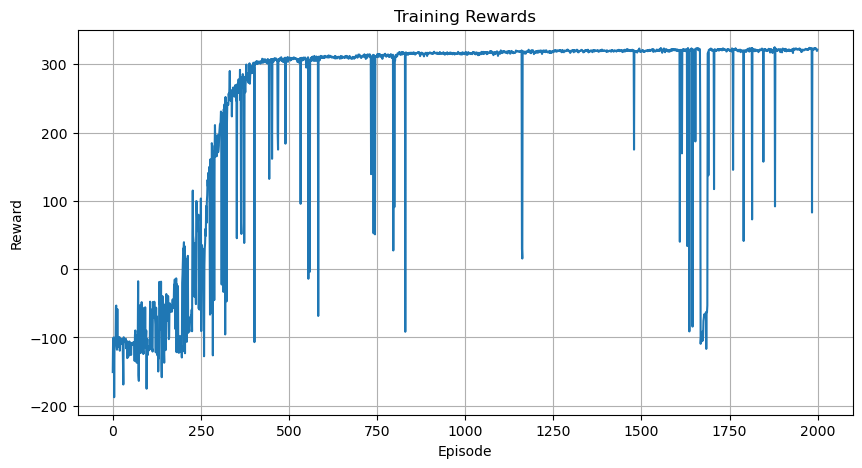

In [ ]:
# Start training
# Set render=True to see the agent learning in real-time (Note: this may slow down training)
print(f"Starting BipedalWalker training on {device}...")

# Configurable Hyperparameters
MAX_EPISODES = 1000 # Can extend to 2000 if it doesn't converge
UPDATES_PER_STEP = 2  # Higher gradient updates per step for sample efficiency
NUM_ENVS = 4 # Number of parallel environments (vectorized)

rewards, trained_agent = train_agent(
    max_episodes=MAX_EPISODES, 
    device=device, 
    updates_per_step=UPDATES_PER_STEP,
    start_steps=10000,
    num_envs=NUM_ENVS,
    render=True  # Set to True to visualize training
) 
print("Training completed!")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.title("Training Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

## Video Recording and Evaluation

After training, we can record a video of the agent's performance to visually verify its walking ability. This is required for the application.

In [10]:
from gymnasium.wrappers import RecordVideo
from IPython.display import Video
import glob
import os

def record_video(agent, env_name="BipedalWalker-v3", filename="bipedal_walker", device="cpu"):
    # Create environment with render mode
    env = gym.make(env_name, render_mode="rgb_array")
    
    # Wrap environment to record video
    # We force record the first episode
    video_folder = "videos"
    os.makedirs(video_folder, exist_ok=True)
    env = RecordVideo(env, video_folder=video_folder, name_prefix=filename, episode_trigger=lambda x: True)
    
    state, _ = env.reset()
    done = False
    truncated = False
    total_reward = 0
    
    while not (done or truncated):
        # Use deterministic policy for evaluation
        action = agent.select_action(state, deterministic=True)
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
        total_reward += reward
    
    env.close()
    print(f"Evaluation Run - Total Reward: {total_reward:.2f}")
    
    # Find the video file
    mp4_files = glob.glob(f"{video_folder}/{filename}-episode-0.mp4")
    if mp4_files:
        print(f"Video saved to {mp4_files[0]}")
        return mp4_files[0]
    return None

# Record and display video
# Note: You need to have ffmpeg installed for this to work
if 'trained_agent' in locals():
    video_path = record_video(trained_agent, device=device)
    if video_path:
        display(Video(video_path, embed=True, html_attributes="controls autoplay loop"))

/Users/szh/anaconda3/envs/rl-gym/lib/python3.11/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /Users/szh/Documents/SZH/Project/BruinAI/Reinforcement Learning/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Evaluation Run - Total Reward: 325.86
Video saved to videos/bipedal_walker-episode-0.mp4


Starting Ablation Study on Learning Rates...

Testing Learning Rate: 0.001
Initializing SAC Agent on device: mps with LR: 0.001


Training Progress (LR=0.001):   0%|          | 0/500 [00:00<?, ?ep/s]

Training Progress (LR=0.001):   2%|▏         | 10/500 [00:20<24:02,  2.94s/ep, Last Reward=-110.77, Avg Reward (10)=-102.13, Total Steps=1777]

Episode: 10/500 | Reward: -110.77 | Avg Reward (10): -102.13 | Total Steps: 1777


Training Progress (LR=0.001):   4%|▍         | 20/500 [00:52<14:54,  1.86s/ep, Last Reward=-102.94, Avg Reward (10)=-106.60, Total Steps=4212]

Episode: 20/500 | Reward: -102.94 | Avg Reward (10): -106.60 | Total Steps: 4212


Training Progress (LR=0.001):   6%|▌         | 30/500 [01:04<08:22,  1.07s/ep, Last Reward=-103.58, Avg Reward (10)=-105.64, Total Steps=5064]

Episode: 30/500 | Reward: -103.58 | Avg Reward (10): -105.64 | Total Steps: 5064


Training Progress (LR=0.001):   8%|▊         | 40/500 [01:14<07:24,  1.04ep/s, Last Reward=-107.02, Avg Reward (10)=-108.85, Total Steps=5862]

Episode: 40/500 | Reward: -107.02 | Avg Reward (10): -108.85 | Total Steps: 5862


Training Progress (LR=0.001):  10%|█         | 50/500 [01:24<08:24,  1.12s/ep, Last Reward=-104.56, Avg Reward (10)=-111.35, Total Steps=6600]

Episode: 50/500 | Reward: -104.56 | Avg Reward (10): -111.35 | Total Steps: 6600
Checkpoint saved at episode 50


Training Progress (LR=0.001):  12%|█▏        | 60/500 [01:49<22:37,  3.09s/ep, Last Reward=-113.41, Avg Reward (10)=-120.74, Total Steps=8460]

Episode: 60/500 | Reward: -113.41 | Avg Reward (10): -120.74 | Total Steps: 8460


Training Progress (LR=0.001):  14%|█▍        | 70/500 [02:32<35:18,  4.93s/ep, Last Reward=-101.08, Avg Reward (10)=-114.74, Total Steps=11693]

Episode: 70/500 | Reward: -101.08 | Avg Reward (10): -114.74 | Total Steps: 11693


Training Progress (LR=0.001):  16%|█▌        | 80/500 [03:58<27:41,  3.96s/ep, Last Reward=-102.68, Avg Reward (10)=-71.57, Total Steps=18105]  

Episode: 80/500 | Reward: -102.68 | Avg Reward (10): -71.57 | Total Steps: 18105


Training Progress (LR=0.001):  18%|█▊        | 90/500 [04:21<33:31,  4.91s/ep, Last Reward=-47.35, Avg Reward (10)=-97.97, Total Steps=19867]  

Episode: 90/500 | Reward: -47.35 | Avg Reward (10): -97.97 | Total Steps: 19867


Training Progress (LR=0.001):  20%|██        | 100/500 [04:57<17:28,  2.62s/ep, Last Reward=-106.23, Avg Reward (10)=-102.02, Total Steps=22495]

Episode: 100/500 | Reward: -106.23 | Avg Reward (10): -102.02 | Total Steps: 22495
Checkpoint saved at episode 100


Training Progress (LR=0.001):  22%|██▏       | 110/500 [05:27<11:49,  1.82s/ep, Last Reward=-103.96, Avg Reward (10)=-110.37, Total Steps=24742]

Episode: 110/500 | Reward: -103.96 | Avg Reward (10): -110.37 | Total Steps: 24742


Training Progress (LR=0.001):  24%|██▍       | 120/500 [06:41<44:24,  7.01s/ep, Last Reward=-123.17, Avg Reward (10)=-103.81, Total Steps=30248] 

Episode: 120/500 | Reward: -123.17 | Avg Reward (10): -103.81 | Total Steps: 30248


Training Progress (LR=0.001):  26%|██▌       | 130/500 [08:18<1:15:24, 12.23s/ep, Last Reward=-45.42, Avg Reward (10)=-76.48, Total Steps=37499]

Episode: 130/500 | Reward: -45.42 | Avg Reward (10): -76.48 | Total Steps: 37499


Training Progress (LR=0.001):  28%|██▊       | 140/500 [09:09<14:09,  2.36s/ep, Last Reward=-134.90, Avg Reward (10)=-101.33, Total Steps=41288] 

Episode: 140/500 | Reward: -134.90 | Avg Reward (10): -101.33 | Total Steps: 41288


Training Progress (LR=0.001):  30%|███       | 150/500 [10:06<35:11,  6.03s/ep, Last Reward=-120.60, Avg Reward (10)=-92.88, Total Steps=45578] 

Episode: 150/500 | Reward: -120.60 | Avg Reward (10): -92.88 | Total Steps: 45578
Checkpoint saved at episode 150


Training Progress (LR=0.001):  32%|███▏      | 160/500 [11:49<1:10:31, 12.45s/ep, Last Reward=-47.49, Avg Reward (10)=-67.45, Total Steps=53281]

Episode: 160/500 | Reward: -47.49 | Avg Reward (10): -67.45 | Total Steps: 53281


Training Progress (LR=0.001):  34%|███▍      | 170/500 [14:02<1:13:25, 13.35s/ep, Last Reward=-50.25, Avg Reward (10)=-54.77, Total Steps=63192] 

Episode: 170/500 | Reward: -50.25 | Avg Reward (10): -54.77 | Total Steps: 63192


Training Progress (LR=0.001):  36%|███▌      | 180/500 [15:25<48:53,  9.17s/ep, Last Reward=-101.13, Avg Reward (10)=-80.58, Total Steps=69349]  

Episode: 180/500 | Reward: -101.13 | Avg Reward (10): -80.58 | Total Steps: 69349


Training Progress (LR=0.001):  38%|███▊      | 190/500 [16:25<25:39,  4.97s/ep, Last Reward=-100.59, Avg Reward (10)=-69.82, Total Steps=73787]

Episode: 190/500 | Reward: -100.59 | Avg Reward (10): -69.82 | Total Steps: 73787


Training Progress (LR=0.001):  40%|████      | 200/500 [16:50<09:31,  1.91s/ep, Last Reward=-108.71, Avg Reward (10)=-88.67, Total Steps=75672]

Episode: 200/500 | Reward: -108.71 | Avg Reward (10): -88.67 | Total Steps: 75672
Checkpoint saved at episode 200


Training Progress (LR=0.001):  42%|████▏     | 210/500 [18:28<48:25, 10.02s/ep, Last Reward=-94.82, Avg Reward (10)=-59.34, Total Steps=82959] 

Episode: 210/500 | Reward: -94.82 | Avg Reward (10): -59.34 | Total Steps: 82959


Training Progress (LR=0.001):  44%|████▍     | 220/500 [19:28<38:14,  8.19s/ep, Last Reward=105.37, Avg Reward (10)=-44.28, Total Steps=87376] 

Episode: 220/500 | Reward: 105.37 | Avg Reward (10): -44.28 | Total Steps: 87376


Training Progress (LR=0.001):  46%|████▌     | 230/500 [21:32<46:08, 10.25s/ep, Last Reward=-83.93, Avg Reward (10)=83.94, Total Steps=96624] 

Episode: 230/500 | Reward: -83.93 | Avg Reward (10): 83.94 | Total Steps: 96624


Training Progress (LR=0.001):  48%|████▊     | 240/500 [23:20<41:12,  9.51s/ep, Last Reward=30.29, Avg Reward (10)=19.17, Total Steps=104606]  

Episode: 240/500 | Reward: 30.29 | Avg Reward (10): 19.17 | Total Steps: 104606


Training Progress (LR=0.001):  50%|█████     | 250/500 [25:00<35:28,  8.52s/ep, Last Reward=-107.07, Avg Reward (10)=33.04, Total Steps=112059]

Episode: 250/500 | Reward: -107.07 | Avg Reward (10): 33.04 | Total Steps: 112059
Checkpoint saved at episode 250


Training Progress (LR=0.001):  52%|█████▏    | 260/500 [26:11<36:32,  9.13s/ep, Last Reward=162.71, Avg Reward (10)=-10.05, Total Steps=117276] 

Episode: 260/500 | Reward: 162.71 | Avg Reward (10): -10.05 | Total Steps: 117276


Training Progress (LR=0.001):  54%|█████▍    | 270/500 [27:39<44:38, 11.65s/ep, Last Reward=152.29, Avg Reward (10)=24.43, Total Steps=123771]  

Episode: 270/500 | Reward: 152.29 | Avg Reward (10): 24.43 | Total Steps: 123771


Training Progress (LR=0.001):  56%|█████▌    | 280/500 [29:35<44:31, 12.14s/ep, Last Reward=176.38, Avg Reward (10)=128.94, Total Steps=132291]

Episode: 280/500 | Reward: 176.38 | Avg Reward (10): 128.94 | Total Steps: 132291


Training Progress (LR=0.001):  58%|█████▊    | 290/500 [31:27<29:48,  8.51s/ep, Last Reward=-114.09, Avg Reward (10)=14.41, Total Steps=140423]

Episode: 290/500 | Reward: -114.09 | Avg Reward (10): 14.41 | Total Steps: 140423


Training Progress (LR=0.001):  60%|██████    | 300/500 [32:13<10:52,  3.26s/ep, Last Reward=-136.60, Avg Reward (10)=-79.49, Total Steps=143793]

Episode: 300/500 | Reward: -136.60 | Avg Reward (10): -79.49 | Total Steps: 143793
Checkpoint saved at episode 300


Training Progress (LR=0.001):  62%|██████▏   | 310/500 [34:14<30:09,  9.52s/ep, Last Reward=-145.41, Avg Reward (10)=-101.52, Total Steps=152554]

Episode: 310/500 | Reward: -145.41 | Avg Reward (10): -101.52 | Total Steps: 152554


Training Progress (LR=0.001):  64%|██████▍   | 320/500 [36:18<39:00, 13.00s/ep, Last Reward=110.58, Avg Reward (10)=5.67, Total Steps=161481]    

Episode: 320/500 | Reward: 110.58 | Avg Reward (10): 5.67 | Total Steps: 161481


Training Progress (LR=0.001):  66%|██████▌   | 330/500 [38:26<29:13, 10.32s/ep, Last Reward=-128.99, Avg Reward (10)=-2.42, Total Steps=170604]

Episode: 330/500 | Reward: -128.99 | Avg Reward (10): -2.42 | Total Steps: 170604


Training Progress (LR=0.001):  68%|██████▊   | 340/500 [38:44<05:35,  2.10s/ep, Last Reward=-132.06, Avg Reward (10)=-124.50, Total Steps=171877]

Episode: 340/500 | Reward: -132.06 | Avg Reward (10): -124.50 | Total Steps: 171877


Training Progress (LR=0.001):  70%|███████   | 350/500 [39:11<06:59,  2.80s/ep, Last Reward=-125.84, Avg Reward (10)=-136.90, Total Steps=173776]

Episode: 350/500 | Reward: -125.84 | Avg Reward (10): -136.90 | Total Steps: 173776
Checkpoint saved at episode 350


Training Progress (LR=0.001):  72%|███████▏  | 360/500 [41:02<30:54, 13.24s/ep, Last Reward=-52.75, Avg Reward (10)=-83.61, Total Steps=181628]  

Episode: 360/500 | Reward: -52.75 | Avg Reward (10): -83.61 | Total Steps: 181628


Training Progress (LR=0.001):  74%|███████▍  | 370/500 [43:16<28:37, 13.21s/ep, Last Reward=195.22, Avg Reward (10)=58.74, Total Steps=190973] 

Episode: 370/500 | Reward: 195.22 | Avg Reward (10): 58.74 | Total Steps: 190973


Training Progress (LR=0.001):  76%|███████▌  | 380/500 [45:28<27:38, 13.82s/ep, Last Reward=239.76, Avg Reward (10)=195.88, Total Steps=2e+5]  

Episode: 380/500 | Reward: 239.76 | Avg Reward (10): 195.88 | Total Steps: 200229


Training Progress (LR=0.001):  78%|███████▊  | 390/500 [47:36<22:06, 12.06s/ep, Last Reward=94.33, Avg Reward (10)=153.77, Total Steps=208984] 

Episode: 390/500 | Reward: 94.33 | Avg Reward (10): 153.77 | Total Steps: 208984


Training Progress (LR=0.001):  80%|████████  | 400/500 [49:28<21:10, 12.71s/ep, Last Reward=259.85, Avg Reward (10)=131.01, Total Steps=216589]

Episode: 400/500 | Reward: 259.85 | Avg Reward (10): 131.01 | Total Steps: 216589
Checkpoint saved at episode 400


Training Progress (LR=0.001):  82%|████████▏ | 410/500 [50:47<12:36,  8.40s/ep, Last Reward=-33.26, Avg Reward (10)=47.17, Total Steps=221942] 

Episode: 410/500 | Reward: -33.26 | Avg Reward (10): 47.17 | Total Steps: 221942


Training Progress (LR=0.001):  84%|████████▍ | 420/500 [53:07<17:52, 13.41s/ep, Last Reward=258.12, Avg Reward (10)=220.34, Total Steps=231313]

Episode: 420/500 | Reward: 258.12 | Avg Reward (10): 220.34 | Total Steps: 231313


Training Progress (LR=0.001):  86%|████████▌ | 430/500 [55:27<14:16, 12.24s/ep, Last Reward=40.49, Avg Reward (10)=219.98, Total Steps=240616] 

Episode: 430/500 | Reward: 40.49 | Avg Reward (10): 219.98 | Total Steps: 240616


Training Progress (LR=0.001):  88%|████████▊ | 440/500 [57:27<12:12, 12.21s/ep, Last Reward=138.54, Avg Reward (10)=164.90, Total Steps=248558]

Episode: 440/500 | Reward: 138.54 | Avg Reward (10): 164.90 | Total Steps: 248558


Training Progress (LR=0.001):  90%|█████████ | 450/500 [59:40<09:06, 10.94s/ep, Last Reward=67.53, Avg Reward (10)=203.53, Total Steps=257263] 

Episode: 450/500 | Reward: 67.53 | Avg Reward (10): 203.53 | Total Steps: 257263
Checkpoint saved at episode 450


Training Progress (LR=0.001):  92%|█████████▏| 460/500 [1:01:46<09:35, 14.39s/ep, Last Reward=275.06, Avg Reward (10)=180.49, Total Steps=265473]

Episode: 460/500 | Reward: 275.06 | Avg Reward (10): 180.49 | Total Steps: 265473


Training Progress (LR=0.001):  94%|█████████▍| 470/500 [1:04:02<05:37, 11.25s/ep, Last Reward=-129.13, Avg Reward (10)=193.06, Total Steps=274174]

Episode: 470/500 | Reward: -129.13 | Avg Reward (10): 193.06 | Total Steps: 274174


Training Progress (LR=0.001):  96%|█████████▌| 480/500 [1:05:01<02:19,  6.96s/ep, Last Reward=-148.45, Avg Reward (10)=-72.21, Total Steps=277840]

Episode: 480/500 | Reward: -148.45 | Avg Reward (10): -72.21 | Total Steps: 277840


Training Progress (LR=0.001):  98%|█████████▊| 490/500 [1:07:03<02:20, 14.03s/ep, Last Reward=228.14, Avg Reward (10)=135.28, Total Steps=285562] 

Episode: 490/500 | Reward: 228.14 | Avg Reward (10): 135.28 | Total Steps: 285562


Training Progress (LR=0.001): 100%|██████████| 500/500 [1:08:57<00:00,  8.28s/ep, Last Reward=104.34, Avg Reward (10)=96.75, Total Steps=292754] 


Episode: 500/500 | Reward: 104.34 | Avg Reward (10): 96.75 | Total Steps: 292754
Checkpoint saved at episode 500

Testing Learning Rate: 0.0003
Initializing SAC Agent on device: mps with LR: 0.0003


Training Progress (LR=0.0003):   2%|▏         | 10/500 [00:40<53:18,  6.53s/ep, Last Reward=-55.20, Avg Reward (10)=-100.23, Total Steps=3296]

Episode: 10/500 | Reward: -55.20 | Avg Reward (10): -100.23 | Total Steps: 3296


Training Progress (LR=0.0003):   4%|▍         | 20/500 [01:02<15:12,  1.90s/ep, Last Reward=-101.12, Avg Reward (10)=-105.32, Total Steps=4961]

Episode: 20/500 | Reward: -101.12 | Avg Reward (10): -105.32 | Total Steps: 4961


Training Progress (LR=0.0003):   6%|▌         | 30/500 [01:12<07:16,  1.08ep/s, Last Reward=-98.85, Avg Reward (10)=-103.76, Total Steps=5662] 

Episode: 30/500 | Reward: -98.85 | Avg Reward (10): -103.76 | Total Steps: 5662


Training Progress (LR=0.0003):   8%|▊         | 40/500 [01:48<45:02,  5.87s/ep, Last Reward=-104.50, Avg Reward (10)=-96.38, Total Steps=8368] 

Episode: 40/500 | Reward: -104.50 | Avg Reward (10): -96.38 | Total Steps: 8368


Training Progress (LR=0.0003):  10%|█         | 50/500 [02:00<08:48,  1.17s/ep, Last Reward=-104.84, Avg Reward (10)=-108.39, Total Steps=9322]

Episode: 50/500 | Reward: -104.84 | Avg Reward (10): -108.39 | Total Steps: 9322
Checkpoint saved at episode 50


Training Progress (LR=0.0003):  12%|█▏        | 60/500 [02:17<11:48,  1.61s/ep, Last Reward=-114.85, Avg Reward (10)=-111.51, Total Steps=10547]

Episode: 60/500 | Reward: -114.85 | Avg Reward (10): -111.51 | Total Steps: 10547


Training Progress (LR=0.0003):  14%|█▍        | 70/500 [03:27<47:23,  6.61s/ep, Last Reward=-84.79, Avg Reward (10)=-87.09, Total Steps=15824]   

Episode: 70/500 | Reward: -84.79 | Avg Reward (10): -87.09 | Total Steps: 15824


Training Progress (LR=0.0003):  16%|█▌        | 80/500 [03:43<14:20,  2.05s/ep, Last Reward=-102.46, Avg Reward (10)=-111.29, Total Steps=17039]

Episode: 80/500 | Reward: -102.46 | Avg Reward (10): -111.29 | Total Steps: 17039


Training Progress (LR=0.0003):  18%|█▊        | 90/500 [05:02<1:04:24,  9.43s/ep, Last Reward=-78.44, Avg Reward (10)=-89.80, Total Steps=22961] 

Episode: 90/500 | Reward: -78.44 | Avg Reward (10): -89.80 | Total Steps: 22961


Training Progress (LR=0.0003):  20%|██        | 100/500 [06:51<46:22,  6.96s/ep, Last Reward=-118.25, Avg Reward (10)=-71.23, Total Steps=31112] 

Episode: 100/500 | Reward: -118.25 | Avg Reward (10): -71.23 | Total Steps: 31112
Checkpoint saved at episode 100


Training Progress (LR=0.0003):  22%|██▏       | 110/500 [07:47<57:49,  8.90s/ep, Last Reward=-14.09, Avg Reward (10)=-79.96, Total Steps=35300] 

Episode: 110/500 | Reward: -14.09 | Avg Reward (10): -79.96 | Total Steps: 35300


Training Progress (LR=0.0003):  24%|██▍       | 120/500 [09:32<49:09,  7.76s/ep, Last Reward=-120.52, Avg Reward (10)=-25.17, Total Steps=43161]  

Episode: 120/500 | Reward: -120.52 | Avg Reward (10): -25.17 | Total Steps: 43161


Training Progress (LR=0.0003):  26%|██▌       | 130/500 [11:01<1:11:10, 11.54s/ep, Last Reward=2.04, Avg Reward (10)=-24.26, Total Steps=49823] 

Episode: 130/500 | Reward: 2.04 | Avg Reward (10): -24.26 | Total Steps: 49823


Training Progress (LR=0.0003):  28%|██▊       | 140/500 [12:39<57:46,  9.63s/ep, Last Reward=5.06, Avg Reward (10)=-87.35, Total Steps=57145]     

Episode: 140/500 | Reward: 5.06 | Avg Reward (10): -87.35 | Total Steps: 57145


Training Progress (LR=0.0003):  30%|███       | 150/500 [14:30<1:13:02, 12.52s/ep, Last Reward=49.33, Avg Reward (10)=-36.24, Total Steps=65445]  

Episode: 150/500 | Reward: 49.33 | Avg Reward (10): -36.24 | Total Steps: 65445
Checkpoint saved at episode 150


Training Progress (LR=0.0003):  32%|███▏      | 160/500 [16:32<1:12:15, 12.75s/ep, Last Reward=-61.17, Avg Reward (10)=-61.29, Total Steps=74541] 

Episode: 160/500 | Reward: -61.17 | Avg Reward (10): -61.29 | Total Steps: 74541


Training Progress (LR=0.0003):  34%|███▍      | 170/500 [18:31<1:09:10, 12.58s/ep, Last Reward=-35.79, Avg Reward (10)=-15.29, Total Steps=83396]

Episode: 170/500 | Reward: -35.79 | Avg Reward (10): -15.29 | Total Steps: 83396


Training Progress (LR=0.0003):  36%|███▌      | 180/500 [20:08<48:02,  9.01s/ep, Last Reward=-115.95, Avg Reward (10)=-6.40, Total Steps=90668]  

Episode: 180/500 | Reward: -115.95 | Avg Reward (10): -6.40 | Total Steps: 90668


Training Progress (LR=0.0003):  38%|███▊      | 190/500 [22:14<1:07:38, 13.09s/ep, Last Reward=144.76, Avg Reward (10)=113.51, Total Steps=1e+5]

Episode: 190/500 | Reward: 144.76 | Avg Reward (10): 113.51 | Total Steps: 99977


Training Progress (LR=0.0003):  40%|████      | 200/500 [24:27<1:04:49, 12.96s/ep, Last Reward=70.45, Avg Reward (10)=161.61, Total Steps=109854] 

Episode: 200/500 | Reward: 70.45 | Avg Reward (10): 161.61 | Total Steps: 109854
Checkpoint saved at episode 200


Training Progress (LR=0.0003):  42%|████▏     | 210/500 [26:20<43:23,  8.98s/ep, Last Reward=27.07, Avg Reward (10)=150.12, Total Steps=118247]   

Episode: 210/500 | Reward: 27.07 | Avg Reward (10): 150.12 | Total Steps: 118247


Training Progress (LR=0.0003):  44%|████▍     | 220/500 [28:14<48:45, 10.45s/ep, Last Reward=274.56, Avg Reward (10)=181.90, Total Steps=126637]  

Episode: 220/500 | Reward: 274.56 | Avg Reward (10): 181.90 | Total Steps: 126637


Training Progress (LR=0.0003):  46%|████▌     | 230/500 [30:31<1:01:06, 13.58s/ep, Last Reward=282.98, Avg Reward (10)=269.61, Total Steps=136637]

Episode: 230/500 | Reward: 282.98 | Avg Reward (10): 269.61 | Total Steps: 136637


Training Progress (LR=0.0003):  48%|████▊     | 240/500 [32:43<58:54, 13.59s/ep, Last Reward=302.12, Avg Reward (10)=252.20, Total Steps=145760]  

Episode: 240/500 | Reward: 302.12 | Avg Reward (10): 252.20 | Total Steps: 145760


Training Progress (LR=0.0003):  50%|█████     | 250/500 [34:39<53:34, 12.86s/ep, Last Reward=305.25, Avg Reward (10)=219.14, Total Steps=153606]

Episode: 250/500 | Reward: 305.25 | Avg Reward (10): 219.14 | Total Steps: 153606
Checkpoint saved at episode 250


Training Progress (LR=0.0003):  52%|█████▏    | 260/500 [36:57<54:56, 13.74s/ep, Last Reward=307.84, Avg Reward (10)=292.51, Total Steps=162966]

Episode: 260/500 | Reward: 307.84 | Avg Reward (10): 292.51 | Total Steps: 162966


Training Progress (LR=0.0003):  54%|█████▍    | 270/500 [38:51<44:27, 11.60s/ep, Last Reward=306.94, Avg Reward (10)=224.83, Total Steps=170761] 

Episode: 270/500 | Reward: 306.94 | Avg Reward (10): 224.83 | Total Steps: 170761


Training Progress (LR=0.0003):  56%|█████▌    | 280/500 [40:41<39:58, 10.90s/ep, Last Reward=308.05, Avg Reward (10)=210.14, Total Steps=178255]

Episode: 280/500 | Reward: 308.05 | Avg Reward (10): 210.14 | Total Steps: 178255


Training Progress (LR=0.0003):  58%|█████▊    | 290/500 [42:47<42:07, 12.04s/ep, Last Reward=305.23, Avg Reward (10)=276.49, Total Steps=186786]

Episode: 290/500 | Reward: 305.23 | Avg Reward (10): 276.49 | Total Steps: 186786


Training Progress (LR=0.0003):  60%|██████    | 300/500 [45:07<47:07, 14.14s/ep, Last Reward=307.42, Avg Reward (10)=304.59, Total Steps=196026]

Episode: 300/500 | Reward: 307.42 | Avg Reward (10): 304.59 | Total Steps: 196026
Checkpoint saved at episode 300


Training Progress (LR=0.0003):  62%|██████▏   | 310/500 [47:28<43:57, 13.88s/ep, Last Reward=309.29, Avg Reward (10)=280.00, Total Steps=205037]

Episode: 310/500 | Reward: 309.29 | Avg Reward (10): 280.00 | Total Steps: 205037


Training Progress (LR=0.0003):  64%|██████▍   | 320/500 [49:40<39:35, 13.20s/ep, Last Reward=310.12, Avg Reward (10)=260.21, Total Steps=213204]

Episode: 320/500 | Reward: 310.12 | Avg Reward (10): 260.21 | Total Steps: 213204


Training Progress (LR=0.0003):  66%|██████▌   | 330/500 [52:02<40:42, 14.37s/ep, Last Reward=310.13, Avg Reward (10)=285.18, Total Steps=221826]

Episode: 330/500 | Reward: 310.13 | Avg Reward (10): 285.18 | Total Steps: 221826


Training Progress (LR=0.0003):  68%|██████▊   | 340/500 [54:17<36:22, 13.64s/ep, Last Reward=310.54, Avg Reward (10)=310.25, Total Steps=230584]

Episode: 340/500 | Reward: 310.54 | Avg Reward (10): 310.25 | Total Steps: 230584


Training Progress (LR=0.0003):  70%|███████   | 350/500 [56:33<34:13, 13.69s/ep, Last Reward=311.48, Avg Reward (10)=310.95, Total Steps=239353]

Episode: 350/500 | Reward: 311.48 | Avg Reward (10): 310.95 | Total Steps: 239353
Checkpoint saved at episode 350


Training Progress (LR=0.0003):  72%|███████▏  | 360/500 [58:46<31:31, 13.51s/ep, Last Reward=313.07, Avg Reward (10)=312.37, Total Steps=247882]

Episode: 360/500 | Reward: 313.07 | Avg Reward (10): 312.37 | Total Steps: 247882


Training Progress (LR=0.0003):  74%|███████▍  | 370/500 [1:01:00<28:49, 13.30s/ep, Last Reward=313.71, Avg Reward (10)=312.72, Total Steps=256461]

Episode: 370/500 | Reward: 313.71 | Avg Reward (10): 312.72 | Total Steps: 256461


Training Progress (LR=0.0003):  76%|███████▌  | 380/500 [1:03:10<26:02, 13.02s/ep, Last Reward=312.91, Avg Reward (10)=288.51, Total Steps=264756]

Episode: 380/500 | Reward: 312.91 | Avg Reward (10): 288.51 | Total Steps: 264756


Training Progress (LR=0.0003):  78%|███████▊  | 390/500 [1:05:20<22:20, 12.19s/ep, Last Reward=310.30, Avg Reward (10)=281.18, Total Steps=272875]

Episode: 390/500 | Reward: 310.30 | Avg Reward (10): 281.18 | Total Steps: 272875


Training Progress (LR=0.0003):  80%|████████  | 400/500 [1:07:38<23:06, 13.86s/ep, Last Reward=314.56, Avg Reward (10)=313.35, Total Steps=281587]

Episode: 400/500 | Reward: 314.56 | Avg Reward (10): 313.35 | Total Steps: 281587
Checkpoint saved at episode 400


Training Progress (LR=0.0003):  82%|████████▏ | 410/500 [1:09:59<21:28, 14.32s/ep, Last Reward=312.29, Avg Reward (10)=313.84, Total Steps=290364]

Episode: 410/500 | Reward: 312.29 | Avg Reward (10): 313.84 | Total Steps: 290364


Training Progress (LR=0.0003):  84%|████████▍ | 420/500 [1:12:21<18:54, 14.18s/ep, Last Reward=312.02, Avg Reward (10)=313.31, Total Steps=299132]

Episode: 420/500 | Reward: 312.02 | Avg Reward (10): 313.31 | Total Steps: 299132


Training Progress (LR=0.0003):  86%|████████▌ | 430/500 [1:14:42<16:35, 14.22s/ep, Last Reward=317.12, Avg Reward (10)=315.84, Total Steps=307852]

Episode: 430/500 | Reward: 317.12 | Avg Reward (10): 315.84 | Total Steps: 307852


Training Progress (LR=0.0003):  88%|████████▊ | 440/500 [1:17:02<14:05, 14.10s/ep, Last Reward=313.48, Avg Reward (10)=315.14, Total Steps=316528]

Episode: 440/500 | Reward: 313.48 | Avg Reward (10): 315.14 | Total Steps: 316528


Training Progress (LR=0.0003):  90%|█████████ | 450/500 [1:19:22<11:43, 14.06s/ep, Last Reward=316.27, Avg Reward (10)=315.21, Total Steps=325021]

Episode: 450/500 | Reward: 316.27 | Avg Reward (10): 315.21 | Total Steps: 325021
Checkpoint saved at episode 450


Training Progress (LR=0.0003):  92%|█████████▏| 460/500 [1:21:39<09:11, 13.80s/ep, Last Reward=315.82, Avg Reward (10)=315.97, Total Steps=333305]

Episode: 460/500 | Reward: 315.82 | Avg Reward (10): 315.97 | Total Steps: 333305


Training Progress (LR=0.0003):  94%|█████████▍| 470/500 [1:24:00<07:02, 14.07s/ep, Last Reward=315.66, Avg Reward (10)=315.92, Total Steps=341719]

Episode: 470/500 | Reward: 315.66 | Avg Reward (10): 315.92 | Total Steps: 341719


Training Progress (LR=0.0003):  96%|█████████▌| 480/500 [1:26:21<04:39, 13.95s/ep, Last Reward=318.26, Avg Reward (10)=316.55, Total Steps=350125]

Episode: 480/500 | Reward: 318.26 | Avg Reward (10): 316.55 | Total Steps: 350125


Training Progress (LR=0.0003):  98%|█████████▊| 490/500 [1:28:32<02:20, 14.02s/ep, Last Reward=315.78, Avg Reward (10)=278.98, Total Steps=357874]

Episode: 490/500 | Reward: 315.78 | Avg Reward (10): 278.98 | Total Steps: 357874


Training Progress (LR=0.0003): 100%|██████████| 500/500 [1:30:52<00:00, 10.91s/ep, Last Reward=316.20, Avg Reward (10)=316.75, Total Steps=366141]


Episode: 500/500 | Reward: 316.20 | Avg Reward (10): 316.75 | Total Steps: 366141
Checkpoint saved at episode 500

Testing Learning Rate: 0.0001
Initializing SAC Agent on device: mps with LR: 0.0001


Training Progress (LR=0.0001):   2%|▏         | 10/500 [00:55<24:07,  2.95s/ep, Last Reward=-105.09, Avg Reward (10)=-88.68, Total Steps=4435] 

Episode: 10/500 | Reward: -105.09 | Avg Reward (10): -88.68 | Total Steps: 4435


Training Progress (LR=0.0001):   4%|▍         | 20/500 [01:20<31:13,  3.90s/ep, Last Reward=-102.86, Avg Reward (10)=-106.90, Total Steps=6272]

Episode: 20/500 | Reward: -102.86 | Avg Reward (10): -106.90 | Total Steps: 6272


Training Progress (LR=0.0001):   6%|▌         | 30/500 [02:16<1:19:50, 10.19s/ep, Last Reward=-66.54, Avg Reward (10)=-101.07, Total Steps=10492]

Episode: 30/500 | Reward: -66.54 | Avg Reward (10): -101.07 | Total Steps: 10492


Training Progress (LR=0.0001):   8%|▊         | 40/500 [03:41<44:08,  5.76s/ep, Last Reward=-103.58, Avg Reward (10)=-69.35, Total Steps=16918]   

Episode: 40/500 | Reward: -103.58 | Avg Reward (10): -69.35 | Total Steps: 16918


Training Progress (LR=0.0001):  10%|█         | 50/500 [05:26<1:05:08,  8.68s/ep, Last Reward=-121.15, Avg Reward (10)=-114.09, Total Steps=24787]

Episode: 50/500 | Reward: -121.15 | Avg Reward (10): -114.09 | Total Steps: 24787
Checkpoint saved at episode 50


Training Progress (LR=0.0001):  12%|█▏        | 60/500 [07:16<1:32:20, 12.59s/ep, Last Reward=-56.68, Avg Reward (10)=-90.70, Total Steps=33060]  

Episode: 60/500 | Reward: -56.68 | Avg Reward (10): -90.70 | Total Steps: 33060


Training Progress (LR=0.0001):  14%|█▍        | 70/500 [09:14<1:29:18, 12.46s/ep, Last Reward=-68.27, Avg Reward (10)=-64.99, Total Steps=41879] 

Episode: 70/500 | Reward: -68.27 | Avg Reward (10): -64.99 | Total Steps: 41879


Training Progress (LR=0.0001):  16%|█▌        | 80/500 [10:50<56:04,  8.01s/ep, Last Reward=-98.61, Avg Reward (10)=-69.62, Total Steps=49132]   

Episode: 80/500 | Reward: -98.61 | Avg Reward (10): -69.62 | Total Steps: 49132


Training Progress (LR=0.0001):  18%|█▊        | 90/500 [12:10<39:29,  5.78s/ep, Last Reward=-113.71, Avg Reward (10)=-50.07, Total Steps=55042]  

Episode: 90/500 | Reward: -113.71 | Avg Reward (10): -50.07 | Total Steps: 55042


Training Progress (LR=0.0001):  20%|██        | 100/500 [12:44<09:37,  1.44s/ep, Last Reward=-116.18, Avg Reward (10)=-104.32, Total Steps=57607]

Episode: 100/500 | Reward: -116.18 | Avg Reward (10): -104.32 | Total Steps: 57607
Checkpoint saved at episode 100


Training Progress (LR=0.0001):  22%|██▏       | 110/500 [13:30<29:17,  4.51s/ep, Last Reward=-115.14, Avg Reward (10)=-105.96, Total Steps=61019]

Episode: 110/500 | Reward: -115.14 | Avg Reward (10): -105.96 | Total Steps: 61019


Training Progress (LR=0.0001):  24%|██▍       | 120/500 [14:57<1:09:21, 10.95s/ep, Last Reward=-43.24, Avg Reward (10)=-71.76, Total Steps=67569]

Episode: 120/500 | Reward: -43.24 | Avg Reward (10): -71.76 | Total Steps: 67569


Training Progress (LR=0.0001):  26%|██▌       | 130/500 [17:01<1:12:11, 11.71s/ep, Last Reward=-26.07, Avg Reward (10)=-61.95, Total Steps=76805] 

Episode: 130/500 | Reward: -26.07 | Avg Reward (10): -61.95 | Total Steps: 76805


Training Progress (LR=0.0001):  28%|██▊       | 140/500 [19:15<1:20:19, 13.39s/ep, Last Reward=-39.66, Avg Reward (10)=-42.03, Total Steps=86805]

Episode: 140/500 | Reward: -39.66 | Avg Reward (10): -42.03 | Total Steps: 86805


Training Progress (LR=0.0001):  30%|███       | 150/500 [20:42<1:03:57, 10.97s/ep, Last Reward=-33.45, Avg Reward (10)=-63.45, Total Steps=93275] 

Episode: 150/500 | Reward: -33.45 | Avg Reward (10): -63.45 | Total Steps: 93275
Checkpoint saved at episode 150


Training Progress (LR=0.0001):  32%|███▏      | 160/500 [22:57<1:16:05, 13.43s/ep, Last Reward=-29.93, Avg Reward (10)=-34.01, Total Steps=103275]

Episode: 160/500 | Reward: -29.93 | Avg Reward (10): -34.01 | Total Steps: 103275


Training Progress (LR=0.0001):  34%|███▍      | 170/500 [25:13<1:14:41, 13.58s/ep, Last Reward=-22.88, Avg Reward (10)=-24.88, Total Steps=113275]

Episode: 170/500 | Reward: -22.88 | Avg Reward (10): -24.88 | Total Steps: 113275


Training Progress (LR=0.0001):  36%|███▌      | 180/500 [27:03<1:04:04, 12.01s/ep, Last Reward=5.97, Avg Reward (10)=-31.03, Total Steps=121416]   

Episode: 180/500 | Reward: 5.97 | Avg Reward (10): -31.03 | Total Steps: 121416


Training Progress (LR=0.0001):  38%|███▊      | 190/500 [28:14<52:03, 10.08s/ep, Last Reward=-37.34, Avg Reward (10)=-68.44, Total Steps=126623]   

Episode: 190/500 | Reward: -37.34 | Avg Reward (10): -68.44 | Total Steps: 126623


Training Progress (LR=0.0001):  40%|████      | 200/500 [30:04<1:05:24, 13.08s/ep, Last Reward=-7.15, Avg Reward (10)=-24.76, Total Steps=134643]

Episode: 200/500 | Reward: -7.15 | Avg Reward (10): -24.76 | Total Steps: 134643
Checkpoint saved at episode 200


Training Progress (LR=0.0001):  42%|████▏     | 210/500 [31:48<46:19,  9.58s/ep, Last Reward=-121.42, Avg Reward (10)=-34.21, Total Steps=142214]  

Episode: 210/500 | Reward: -121.42 | Avg Reward (10): -34.21 | Total Steps: 142214


Training Progress (LR=0.0001):  44%|████▍     | 220/500 [33:15<32:38,  6.99s/ep, Last Reward=-115.33, Avg Reward (10)=-53.10, Total Steps=148465]

Episode: 220/500 | Reward: -115.33 | Avg Reward (10): -53.10 | Total Steps: 148465


Training Progress (LR=0.0001):  46%|████▌     | 230/500 [34:55<54:00, 12.00s/ep, Last Reward=-24.88, Avg Reward (10)=-44.59, Total Steps=155706] 

Episode: 230/500 | Reward: -24.88 | Avg Reward (10): -44.59 | Total Steps: 155706


Training Progress (LR=0.0001):  48%|████▊     | 240/500 [37:01<58:43, 13.55s/ep, Last Reward=-37.13, Avg Reward (10)=-38.78, Total Steps=164757] 

Episode: 240/500 | Reward: -37.13 | Avg Reward (10): -38.78 | Total Steps: 164757


Training Progress (LR=0.0001):  50%|█████     | 250/500 [39:21<58:37, 14.07s/ep, Last Reward=-29.17, Avg Reward (10)=-34.66, Total Steps=174757]

Episode: 250/500 | Reward: -29.17 | Avg Reward (10): -34.66 | Total Steps: 174757
Checkpoint saved at episode 250


Training Progress (LR=0.0001):  52%|█████▏    | 260/500 [41:29<44:27, 11.12s/ep, Last Reward=-100.70, Avg Reward (10)=-50.69, Total Steps=183815]

Episode: 260/500 | Reward: -100.70 | Avg Reward (10): -50.69 | Total Steps: 183815


Training Progress (LR=0.0001):  54%|█████▍    | 270/500 [43:17<36:38,  9.56s/ep, Last Reward=46.54, Avg Reward (10)=-47.41, Total Steps=191419]  

Episode: 270/500 | Reward: 46.54 | Avg Reward (10): -47.41 | Total Steps: 191419


Training Progress (LR=0.0001):  56%|█████▌    | 280/500 [45:29<45:23, 12.38s/ep, Last Reward=1.89, Avg Reward (10)=-5.20, Total Steps=2e+5]      

Episode: 280/500 | Reward: 1.89 | Avg Reward (10): -5.20 | Total Steps: 200471


Training Progress (LR=0.0001):  58%|█████▊    | 290/500 [47:45<49:20, 14.10s/ep, Last Reward=29.71, Avg Reward (10)=15.20, Total Steps=209895]  

Episode: 290/500 | Reward: 29.71 | Avg Reward (10): 15.20 | Total Steps: 209895


Training Progress (LR=0.0001):  60%|██████    | 300/500 [50:00<47:39, 14.30s/ep, Last Reward=43.72, Avg Reward (10)=13.61, Total Steps=219026] 

Episode: 300/500 | Reward: 43.72 | Avg Reward (10): 13.61 | Total Steps: 219026
Checkpoint saved at episode 300


Training Progress (LR=0.0001):  62%|██████▏   | 310/500 [52:21<40:00, 12.63s/ep, Last Reward=-66.21, Avg Reward (10)=4.18, Total Steps=228519]  

Episode: 310/500 | Reward: -66.21 | Avg Reward (10): 4.18 | Total Steps: 228519


Training Progress (LR=0.0001):  64%|██████▍   | 320/500 [54:26<42:02, 14.01s/ep, Last Reward=-20.81, Avg Reward (10)=17.97, Total Steps=236859] 

Episode: 320/500 | Reward: -20.81 | Avg Reward (10): 17.97 | Total Steps: 236859


Training Progress (LR=0.0001):  66%|██████▌   | 330/500 [56:33<41:34, 14.67s/ep, Last Reward=71.11, Avg Reward (10)=47.39, Total Steps=245210] 

Episode: 330/500 | Reward: 71.11 | Avg Reward (10): 47.39 | Total Steps: 245210


Training Progress (LR=0.0001):  68%|██████▊   | 340/500 [59:05<40:41, 15.26s/ep, Last Reward=108.69, Avg Reward (10)=95.85, Total Steps=255210]

Episode: 340/500 | Reward: 108.69 | Avg Reward (10): 95.85 | Total Steps: 255210


Training Progress (LR=0.0001):  70%|███████   | 350/500 [1:01:39<38:40, 15.47s/ep, Last Reward=96.94, Avg Reward (10)=109.35, Total Steps=265210] 

Episode: 350/500 | Reward: 96.94 | Avg Reward (10): 109.35 | Total Steps: 265210
Checkpoint saved at episode 350


Training Progress (LR=0.0001):  72%|███████▏  | 360/500 [1:04:15<36:21, 15.58s/ep, Last Reward=113.16, Avg Reward (10)=123.60, Total Steps=275210]

Episode: 360/500 | Reward: 113.16 | Avg Reward (10): 123.60 | Total Steps: 275210


Training Progress (LR=0.0001):  74%|███████▍  | 370/500 [1:06:43<32:35, 15.04s/ep, Last Reward=124.16, Avg Reward (10)=103.75, Total Steps=284650] 

Episode: 370/500 | Reward: 124.16 | Avg Reward (10): 103.75 | Total Steps: 284650


Training Progress (LR=0.0001):  76%|███████▌  | 380/500 [1:09:21<31:50, 15.92s/ep, Last Reward=131.08, Avg Reward (10)=138.47, Total Steps=294650]

Episode: 380/500 | Reward: 131.08 | Avg Reward (10): 138.47 | Total Steps: 294650


Training Progress (LR=0.0001):  78%|███████▊  | 390/500 [1:12:02<29:31, 16.10s/ep, Last Reward=152.71, Avg Reward (10)=143.09, Total Steps=304650]

Episode: 390/500 | Reward: 152.71 | Avg Reward (10): 143.09 | Total Steps: 304650


Training Progress (LR=0.0001):  80%|████████  | 400/500 [1:14:42<27:11, 16.31s/ep, Last Reward=171.36, Avg Reward (10)=140.81, Total Steps=314498]

Episode: 400/500 | Reward: 171.36 | Avg Reward (10): 140.81 | Total Steps: 314498
Checkpoint saved at episode 400


Training Progress (LR=0.0001):  82%|████████▏ | 410/500 [1:17:27<24:47, 16.53s/ep, Last Reward=159.02, Avg Reward (10)=156.40, Total Steps=324498]

Episode: 410/500 | Reward: 159.02 | Avg Reward (10): 156.40 | Total Steps: 324498


Training Progress (LR=0.0001):  84%|████████▍ | 420/500 [1:20:13<22:11, 16.65s/ep, Last Reward=187.57, Avg Reward (10)=159.07, Total Steps=334498]

Episode: 420/500 | Reward: 187.57 | Avg Reward (10): 159.07 | Total Steps: 334498


Training Progress (LR=0.0001):  86%|████████▌ | 430/500 [1:22:54<18:56, 16.23s/ep, Last Reward=158.22, Avg Reward (10)=133.47, Total Steps=344088]

Episode: 430/500 | Reward: 158.22 | Avg Reward (10): 133.47 | Total Steps: 344088


Training Progress (LR=0.0001):  88%|████████▊ | 440/500 [1:25:42<16:53, 16.89s/ep, Last Reward=173.84, Avg Reward (10)=169.12, Total Steps=354088]

Episode: 440/500 | Reward: 173.84 | Avg Reward (10): 169.12 | Total Steps: 354088


Training Progress (LR=0.0001):  90%|█████████ | 450/500 [1:28:29<13:51, 16.64s/ep, Last Reward=174.60, Avg Reward (10)=155.54, Total Steps=363955]

Episode: 450/500 | Reward: 174.60 | Avg Reward (10): 155.54 | Total Steps: 363955
Checkpoint saved at episode 450


Training Progress (LR=0.0001):  92%|█████████▏| 460/500 [1:31:19<11:21, 17.05s/ep, Last Reward=185.80, Avg Reward (10)=175.29, Total Steps=373955]

Episode: 460/500 | Reward: 185.80 | Avg Reward (10): 175.29 | Total Steps: 373955


Training Progress (LR=0.0001):  94%|█████████▍| 470/500 [1:34:10<08:36, 17.21s/ep, Last Reward=198.50, Avg Reward (10)=193.23, Total Steps=383955]

Episode: 470/500 | Reward: 198.50 | Avg Reward (10): 193.23 | Total Steps: 383955


Training Progress (LR=0.0001):  96%|█████████▌| 480/500 [1:36:54<05:34, 16.73s/ep, Last Reward=194.56, Avg Reward (10)=167.69, Total Steps=393403]

Episode: 480/500 | Reward: 194.56 | Avg Reward (10): 167.69 | Total Steps: 393403


Training Progress (LR=0.0001):  98%|█████████▊| 490/500 [1:39:50<02:55, 17.58s/ep, Last Reward=196.00, Avg Reward (10)=198.07, Total Steps=403403]

Episode: 490/500 | Reward: 196.00 | Avg Reward (10): 198.07 | Total Steps: 403403


Training Progress (LR=0.0001): 100%|██████████| 500/500 [1:42:35<00:00, 12.31s/ep, Last Reward=191.77, Avg Reward (10)=170.37, Total Steps=412643]


Episode: 500/500 | Reward: 191.77 | Avg Reward (10): 170.37 | Total Steps: 412643
Checkpoint saved at episode 500
Ablation study completed. Plotting results...


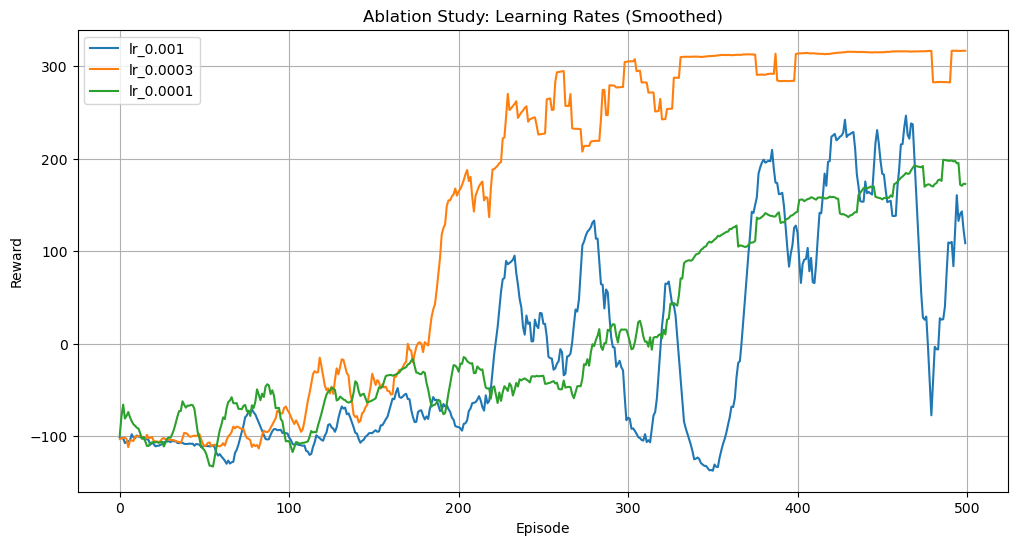

In [11]:
def run_ablation_study(device="cpu"):
    # Compare different learning rates
    learning_rates = [1e-3, 3e-4, 1e-4]
    results = {}
    
    print("Starting Ablation Study on Learning Rates...")
    
    # Create logs directory if it doesn't exist
    os.makedirs("logs", exist_ok=True)
    
    for lr in learning_rates:
        print(f"\nTesting Learning Rate: {lr}")
        # Run training for fewer episodes for ablation study to save time, or full duration if desired
        # Using 500 episodes for ablation study demonstration
        ablation_episodes = 500 
        rewards, _ = train_agent(max_episodes=ablation_episodes, device=device, learning_rate=lr)
        results[f"lr_{lr}"] = rewards
        
        # Save intermediate result
        np.save(f"logs/ablation_rewards_lr_{lr}.npy", rewards)
    
    print("Ablation study completed. Plotting results...")
    
    # Plot results
    plt.figure(figsize=(12, 6))
    for name, rewards in results.items():
        # Smooth rewards for better visualization
        window = 10
        smoothed_rewards = [np.mean(rewards[max(0, i-window):i+1]) for i in range(len(rewards))]
        plt.plot(smoothed_rewards, label=name)
        
    plt.title("Ablation Study: Learning Rates (Smoothed)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the ablation study
run_ablation_study(device=device)

# AISF Application Writeup

## Applicant Information
- **Name**: [Your Name]
- **Email**: [Your Email]

## Prior Experience
*Briefly describe any prior experience you have in RL, Deep Learning, and coding.*

## Time Breakdown
*Total hours spent: X hours*
- Research/Reading: X hours
- Coding: X hours
- Training/Tuning: X hours
- Writing: X hours

## Compute Resources
*Describe the hardware used.*
- CPU: [Number of threads, Model]
- GPU: [Model] (if applicable)

## Techniques Used
*List the techniques used (e.g., SAC, Double Q-Learning, Soft Updates) and justify why they are suitable for this environment.*

## Ablation Studies
*Summarize the results of your ablation studies here. What hyperparameters did you tweak? What was the impact?*

## Discussion of Issues
*Discuss challenges encountered, ideas that didn't work, and how you pivoted.*

## Conclusion
*Summarize what worked well and what could be improved with more time.*

## Citations
- [Haarnoja, T., et al. "Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." arXiv preprint arXiv:1801.01290 (2018).](https://arxiv.org/abs/1801.01290)
- [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/)